In [1]:
import sys
sys.path.append("/home/qrr2/project/")
sys.path.append("/home/qrr2/project/QOGS/")
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import h5py as h5
import qutip as qt
from qutip import tensor, basis,qeye,sigmax,sigmay,sigmaz, destroy, create, num, fock
from qutip import *
from importlib import reload
from scipy.optimize import curve_fit
import scipy.optimize as opt
from scipy.interpolate import InterpolatedUnivariateSpline
from matplotlib.colors import ListedColormap
from scipy.optimize import minimize, LinearConstraint
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from scipy import signal
from scipy.interpolate import interp1d
from scipy.spatial import distance
import matplotlib.colors
from scipy.stats import linregress
from qutip import Qobj
from scipy.stats import poisson
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def get_datasets_between_timestamps(h5filename, start_time, end_time):
    with h5.File(h5filename, 'r') as f:
        datasets = list(f.keys())
    filtered_datasets = [ds for ds in datasets if start_time <= ds <= end_time]
    return filtered_datasets

def truncate_data(data, max_time=10):
    mask = data[0] <= max_time
    return np.array([data[0][mask], data[1][mask]])

def read_1D_data(file_name, h5filename):
    with h5.File(h5filename, 'r') as f:
        dataset = f[file_name]
        return np.array([dataset['xdata'][:], dataset['ydata'][:]])

def fit_qubit_phonon_interaction_normalization(data, g, T1_q, T2_q_pure, T1_p, target_basis):
    xdata = data[0]
    ydata = data[1]

    def Fock_n_Rabi(g, T1_q, T2_q_pure, T1_p, t_list, Fock_num):
        gamma1_q = 1 / T1_q
        gamma2_q = 1 / T2_q_pure
        gamma1_p = 1 / T1_p
        qubit_dim = 2
        phonon_dim = Fock_num + 2
        q_en = tensor(num(qubit_dim), qeye(phonon_dim))
        swap = tensor(destroy(qubit_dim), create(phonon_dim))
        q_ani = tensor(destroy(qubit_dim), qeye(phonon_dim))
        p_ani = tensor(qeye(qubit_dim), destroy(phonon_dim))
        H_JC = 2 * np.pi * (g * swap + g * swap.dag())
        H_tot = H_JC
        c_ops = [np.sqrt(gamma1_q) * q_ani, np.sqrt(gamma2_q) * q_en, np.sqrt(gamma1_p) * p_ani]
        initial_state = tensor(qt.fock(qubit_dim, 1), qt.fock(phonon_dim, Fock_num))
        result = qt.mesolve(H_tot, initial_state, t_list, c_ops, [q_en])
        return result.expect[0]

    time_data = xdata + 0.05
    time_data = np.insert(time_data, 0, 0)
    simulated_y = Fock_n_Rabi(g, T1_q, T2_q_pure, T1_p, time_data, 0)[1:]

    def objective(params):
        a, b = params
        return np.sum(np.square(a * simulated_y + b - ydata))

    initial_guess = [1, 1]
    result = minimize(objective, initial_guess)
    a_optimized, b_optimized = result.x
    basis_list = [Fock_n_Rabi(g, T1_q, T2_q_pure, T1_p, time_data, i)[1:] for i in range(target_basis)]
    return a_optimized, b_optimized, np.array(basis_list)

def square_sum(g, target, basis):
    summation = g[-2] * np.dot(g[:-2], basis) + g[-1]
    return np.sum(np.square(target - summation))

def fit_function(k, lamb):
    return poisson.pmf(k, lamb)

def plot_fitting(x_data, target_data, file_name, a, b, basis_list, target_basis, initial_guess=None):
    fitted_basis = basis_list[:target_basis]
    bounds = [(0, 1) for _ in range(target_basis)] + [(None, None), (None, None)]
    const = LinearConstraint(np.array([1] * target_basis + [0] + [0]), 1, 1)

    if initial_guess is None:
        x0 = [0] * target_basis + [0] + [0]
    else:
        x0 = initial_guess + [0, 0]

    result = minimize(square_sum, x0=x0, bounds=bounds, constraints=const, args=(target_data, fitted_basis))
    se_value = square_sum(result.x, target_data, fitted_basis)
    fitted_population = result.x[:-2] / np.sum(result.x[:-2])
    a = result.x[-2]
    b = result.x[-1]

    plt.figure()
    plt.plot(x_data, target_data, 'o', label='data')
    plt.plot(x_data, a * np.dot(fitted_population, fitted_basis) + b, label='fit')

    label = range(target_basis)
    parameters, cov_matrix = curve_fit(fit_function, label, fitted_population, [3])
    alpha = np.sqrt(parameters[0])
    alpha_err = np.sqrt(np.diag(cov_matrix)[0])

    figure, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), gridspec_kw={'height_ratios': [1, 1]}, constrained_layout=True)
    ax1.set_xlabel('time(us)')
    ax1.set_ylabel('qubit population')
    ax1.legend()
    ax2.set_xlabel(r'phonon Fock state $n$')
    ax2.set_ylabel('population')
    ax2.legend()
    ax1.plot(x_data, a * np.dot(fitted_population, fitted_basis) + b, label='fitted')
    ax1.plot(x_data, target_data, label='experiment')
    ax2.bar(label, fitted_population, alpha=0.5, color='r', edgecolor='black', label='fitted from experiment')
    ax1.set_title('qubit-phonon resonance interaction ' + file_name)
    ax2.bar(label, fit_function(label, *parameters), fc=(1, 1, 1, 0), color='b', edgecolor='black', label='fitted from poisson distribution,alpha ={:.2f}'.format(alpha))
    ax2.set_title('population of each fock state')
    return (alpha, alpha_err, [x_data, np.dot(fitted_population, fitted_basis), target_data, label, fitted_population, fit_function(label, *parameters)], a, b, se_value)

def process_files(h5filename, start_time, end_time, target_fock, target_basis, amps, g, T1q, T2q, T1p, maxtime=10, truncate=False, initial_guess=False):
    file_name_list = get_datasets_between_timestamps(h5filename, start_time, end_time)

    alphas_loose_ab = []
    alpha_errs = []
    a_list = []
    b_list = []
    loose_ab_se_values = []
    average_phonon_numbers = []

    for file_name in file_name_list:
        data = read_1D_data(file_name, h5filename)
        if truncate:
            data = truncate_data(data, max_time=maxtime)
        a, b, basis_list = fit_qubit_phonon_interaction_normalization(data, g, T1q, T2q, T1p, target_basis)
        
        initial_guess_vector = None
        if initial_guess:
            initial_guess_vector = [0] * target_basis
            initial_guess_vector[target_fock] = 1
        
        output = plot_fitting(data[0], data[1], file_name, a, b, basis_list, target_basis, initial_guess=initial_guess_vector)
        loose_ab_se_values.append(output[5])
        a_list.append(output[-3])
        b_list.append(output[-2])
        alphas_loose_ab.append(output[0])
        alpha_errs.append(output[1])
        average_phonon_numbers.append(output[0]**2)  
    
    alpha = [np.sqrt(average_phonon_number) for average_phonon_number in average_phonon_numbers]

    # Plot alpha vs amps
    plt.figure(figsize=(10, 6))
    plt.plot(amps, alpha, 'o--', color='blue', markersize=8)
    plt.xlabel('Amplitude')
    plt.ylabel(r'$\alpha$')
    plt.title('')
    plt.grid()
    
    # Fit a straight line to the plotted data with intercept fixed at 0
    def linear_model(x, slope):
        return slope * x

    popt, _ = curve_fit(linear_model, amps, alpha)
    slope = popt[0]
    plt.plot(amps, slope * np.array(amps), 'r', label=f'Fit: y = {slope:.2f}x')
    plt.legend()

    plt.show()
    
    print(f"Gradient (slope): {slope}")
    print(f"Y-intercept: 0 (fixed)")

# Fock 0 Calibration

/tmp/ipykernel_3365216/2113602726.py:130: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


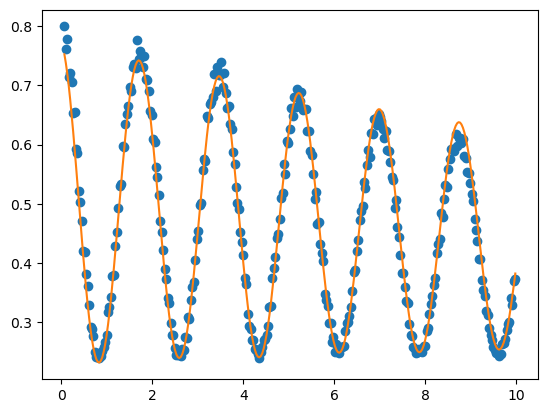

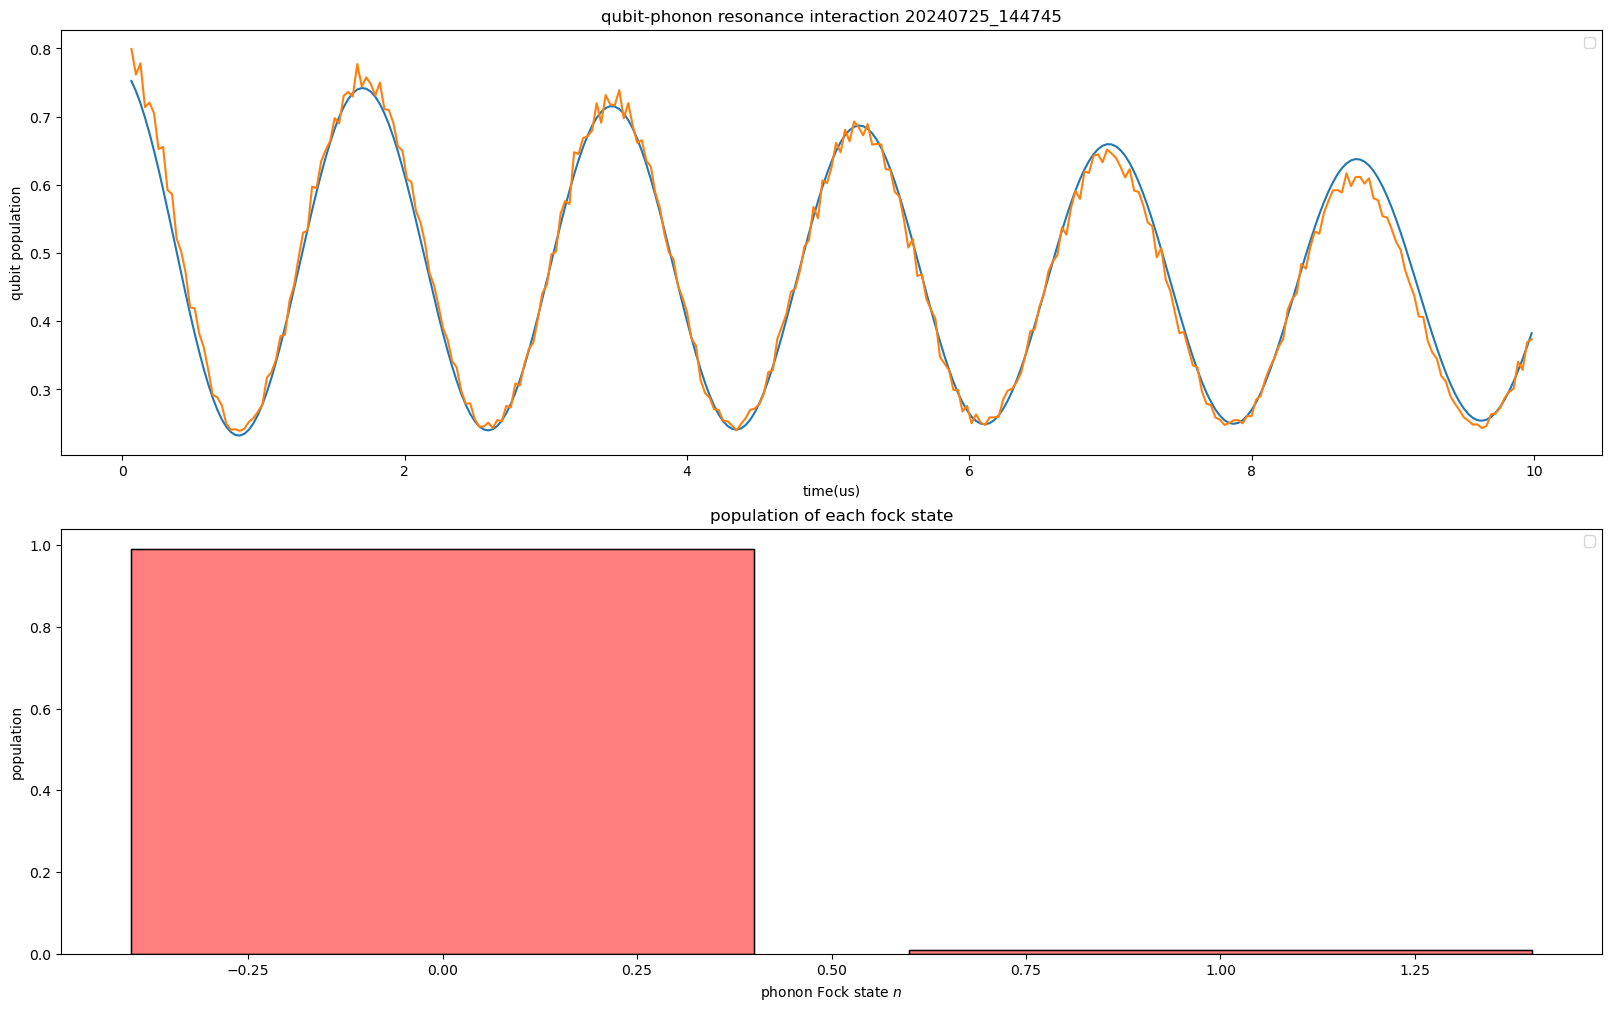

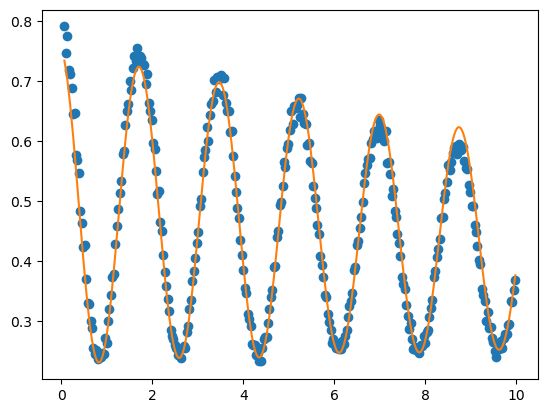

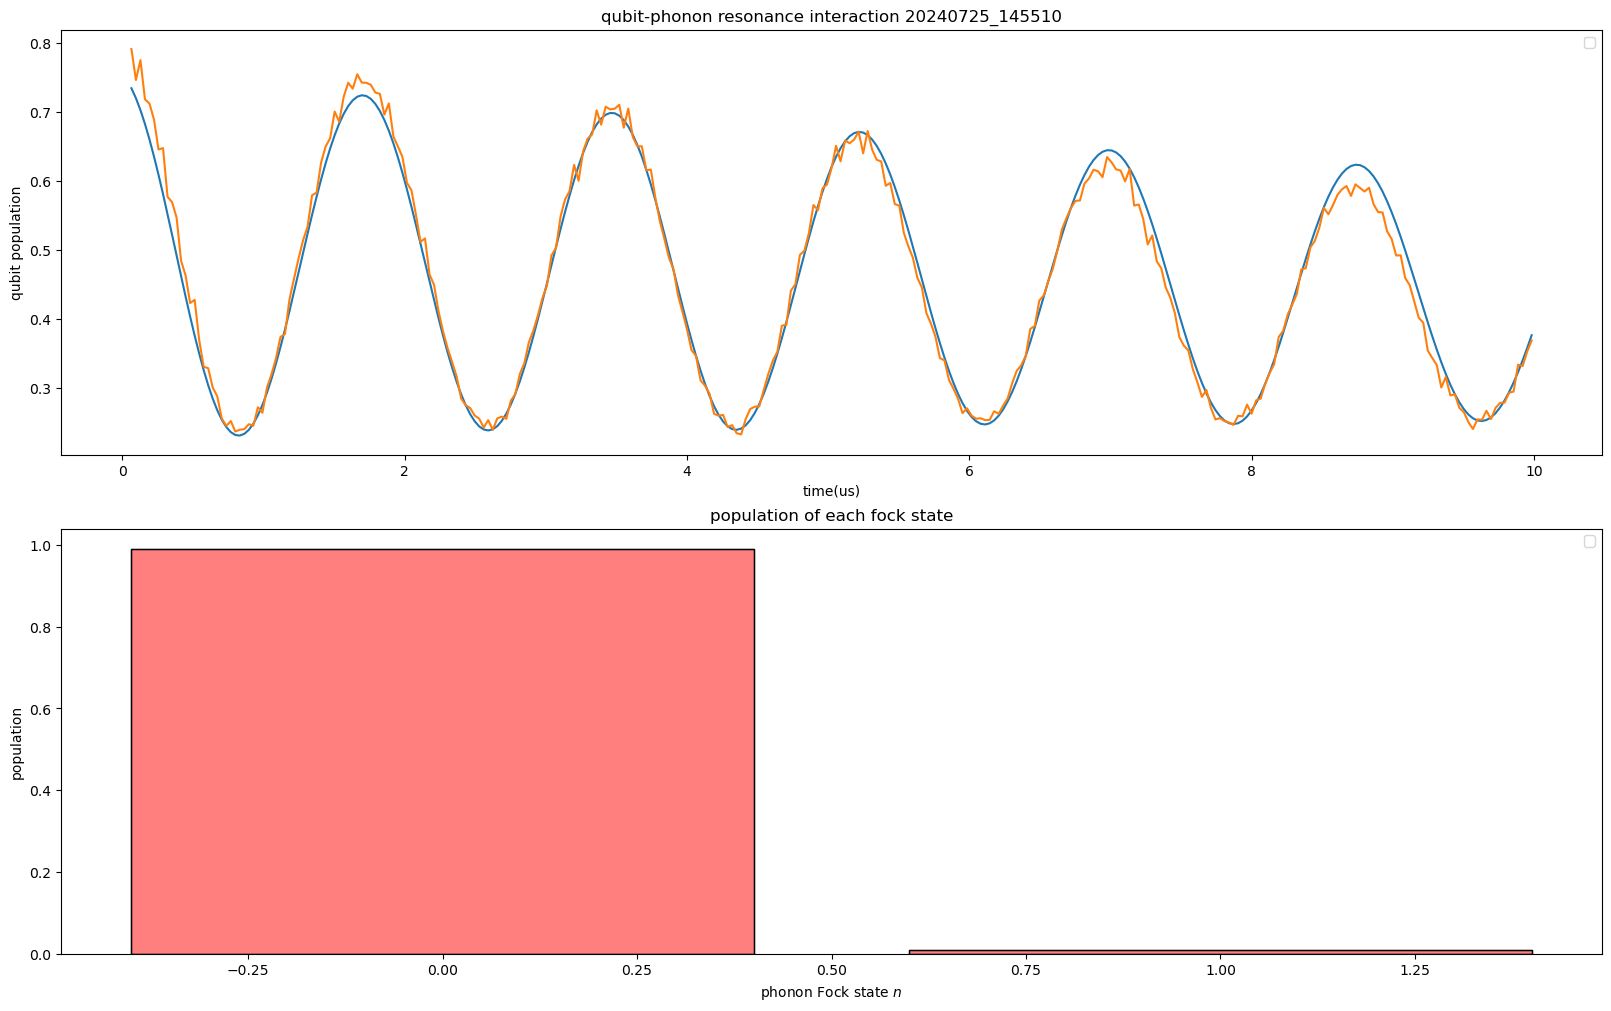

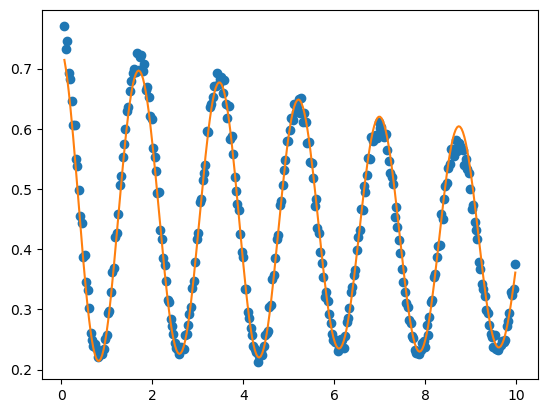

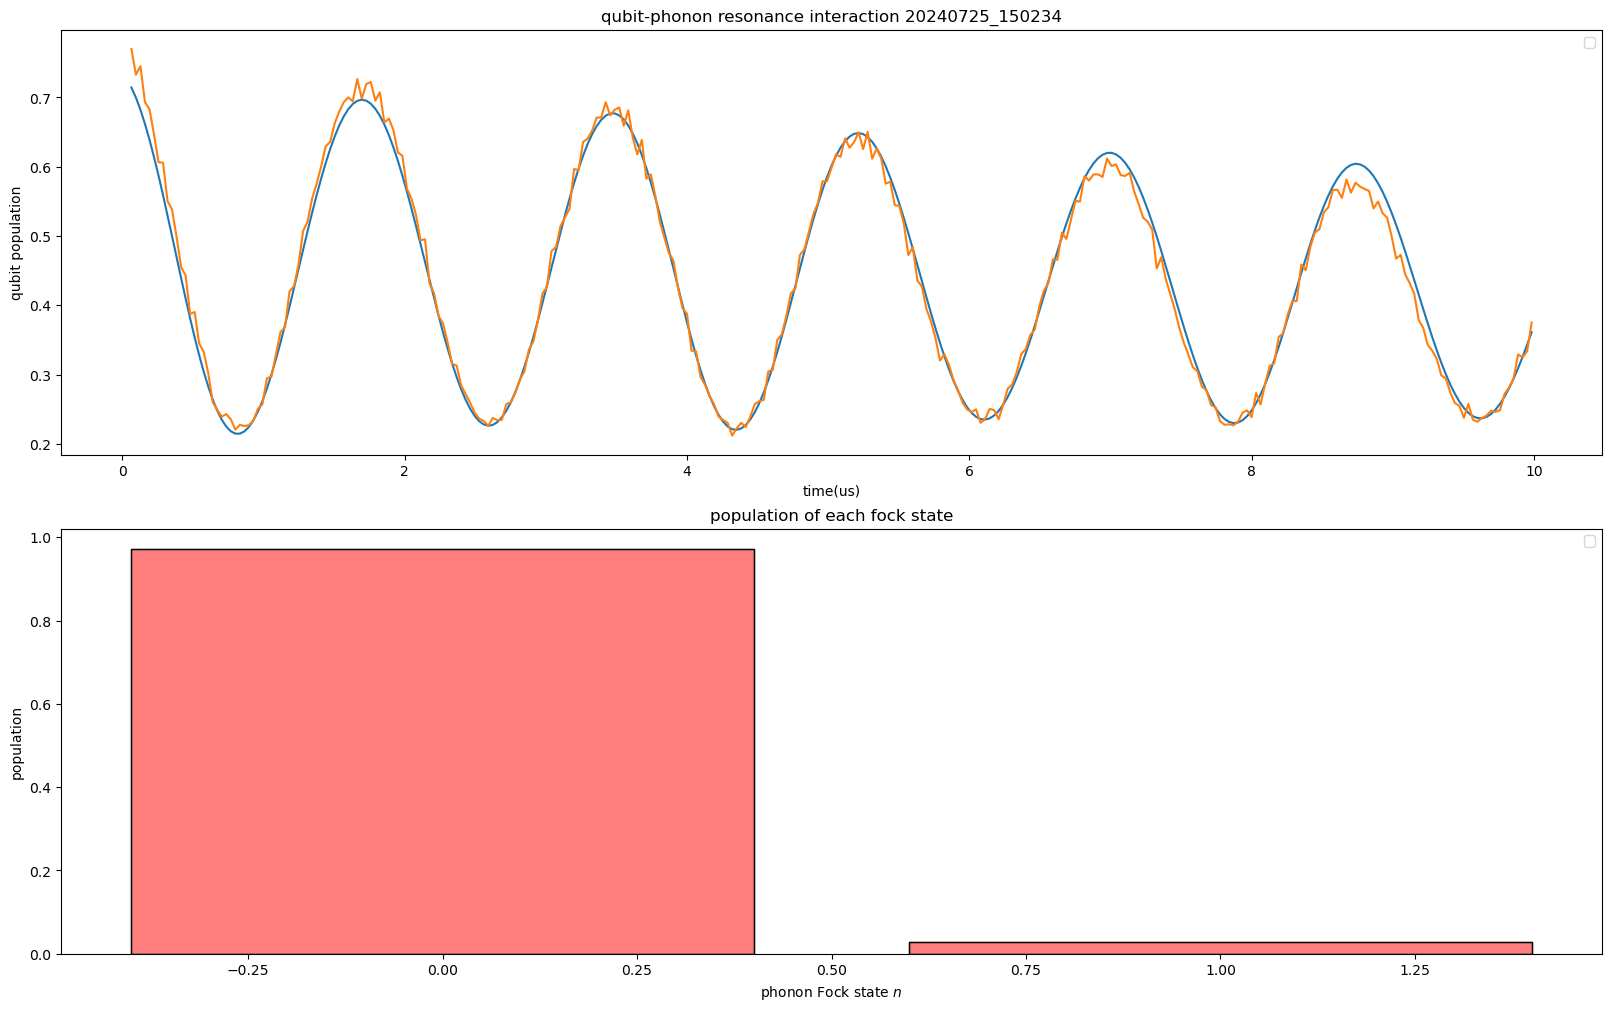

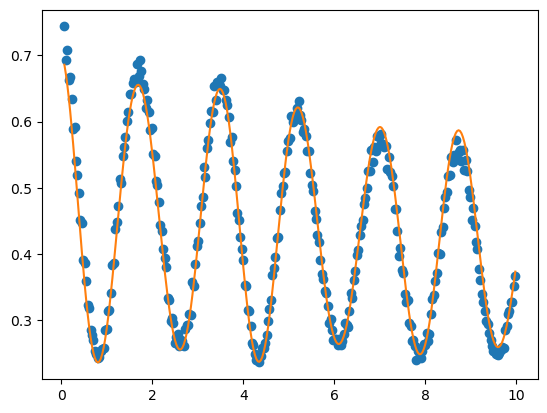

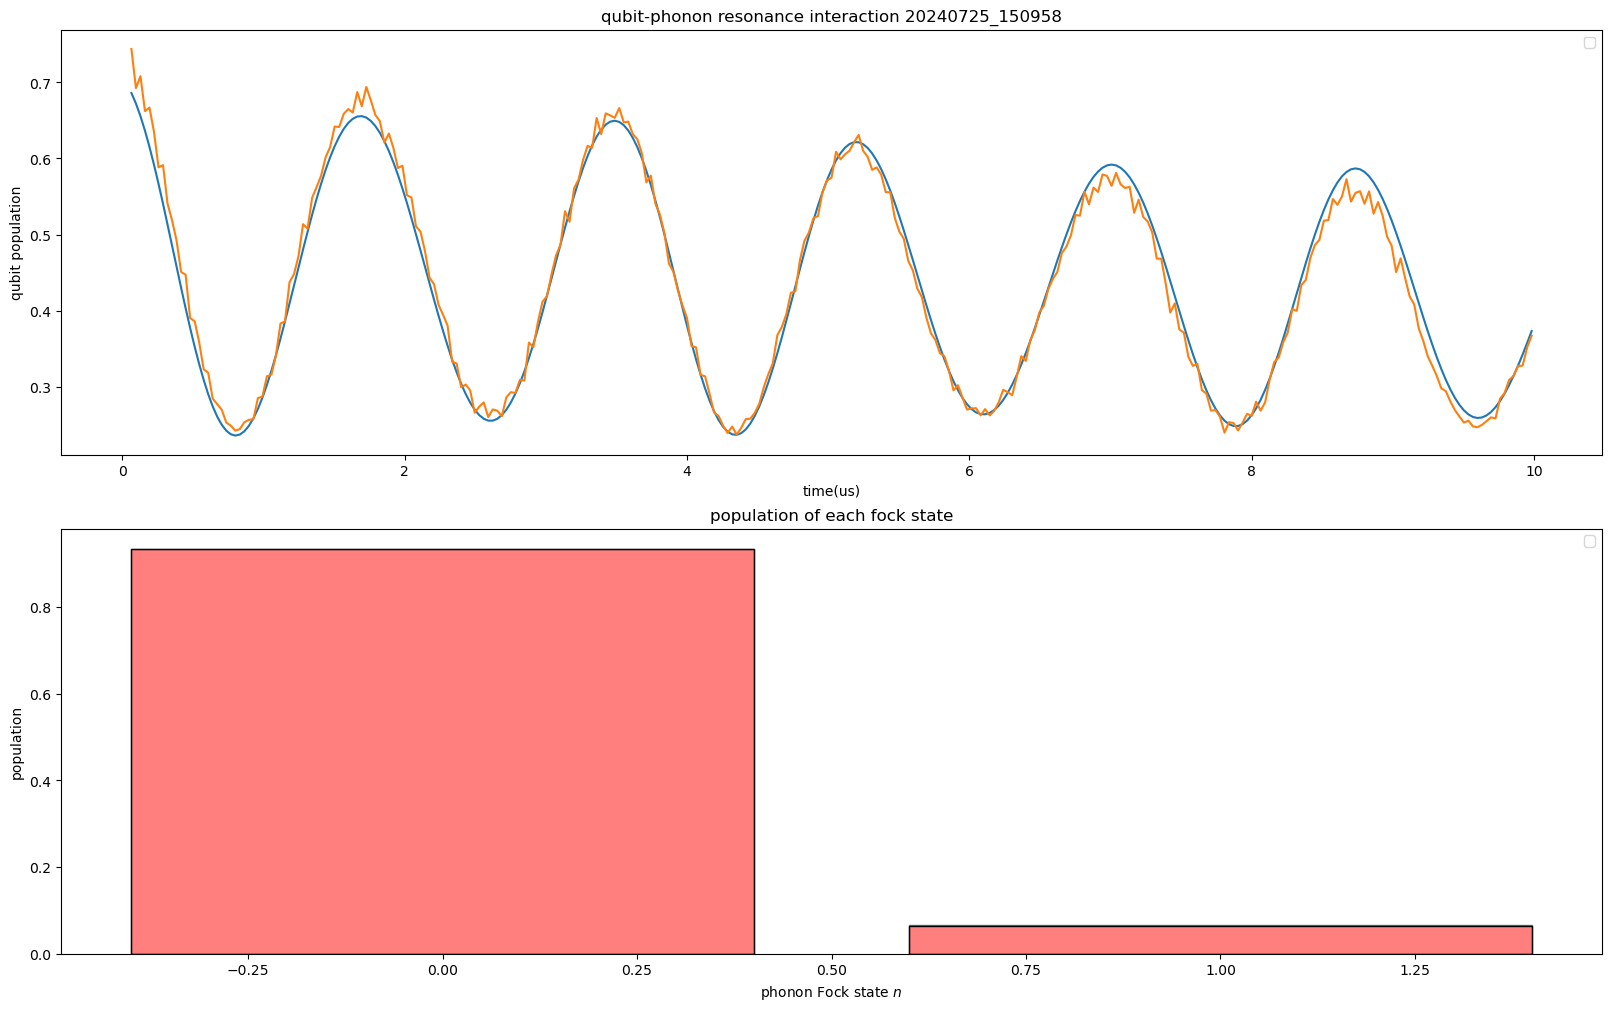

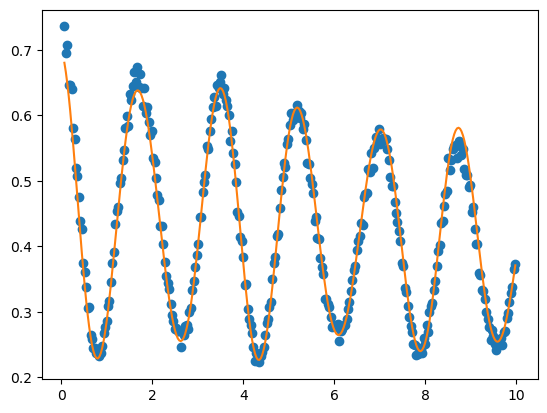

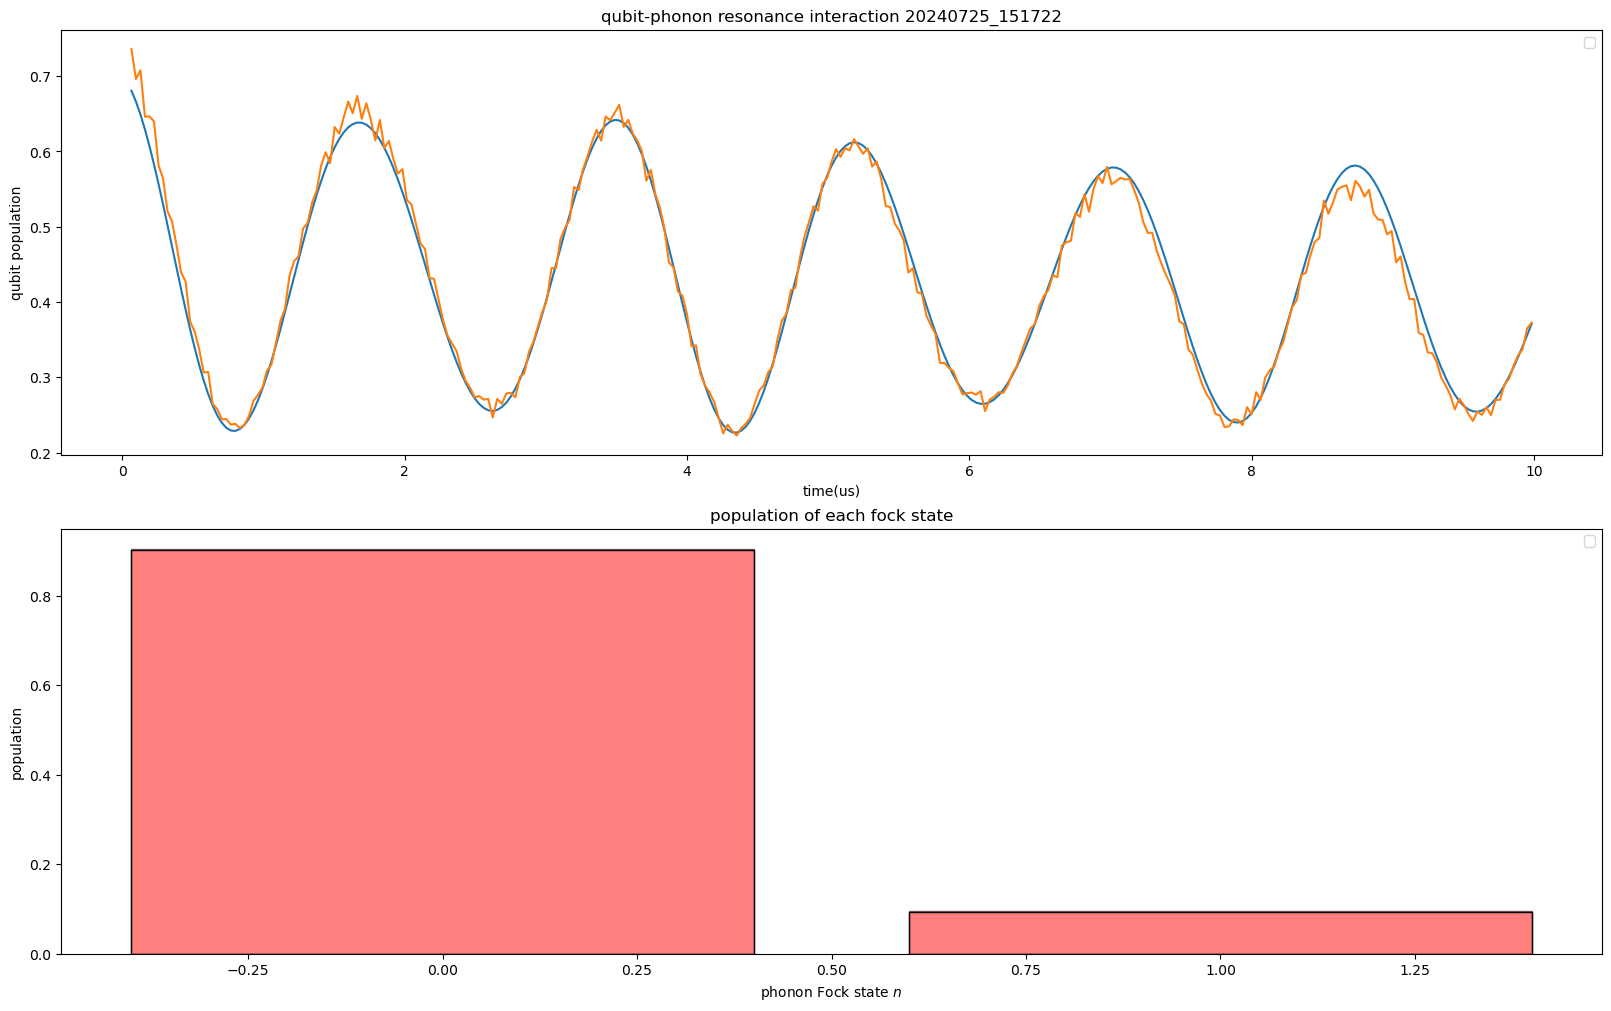

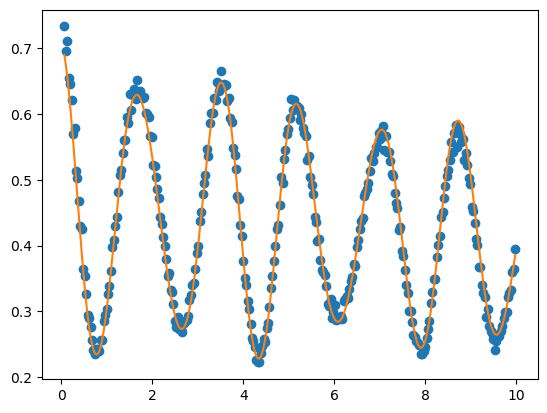

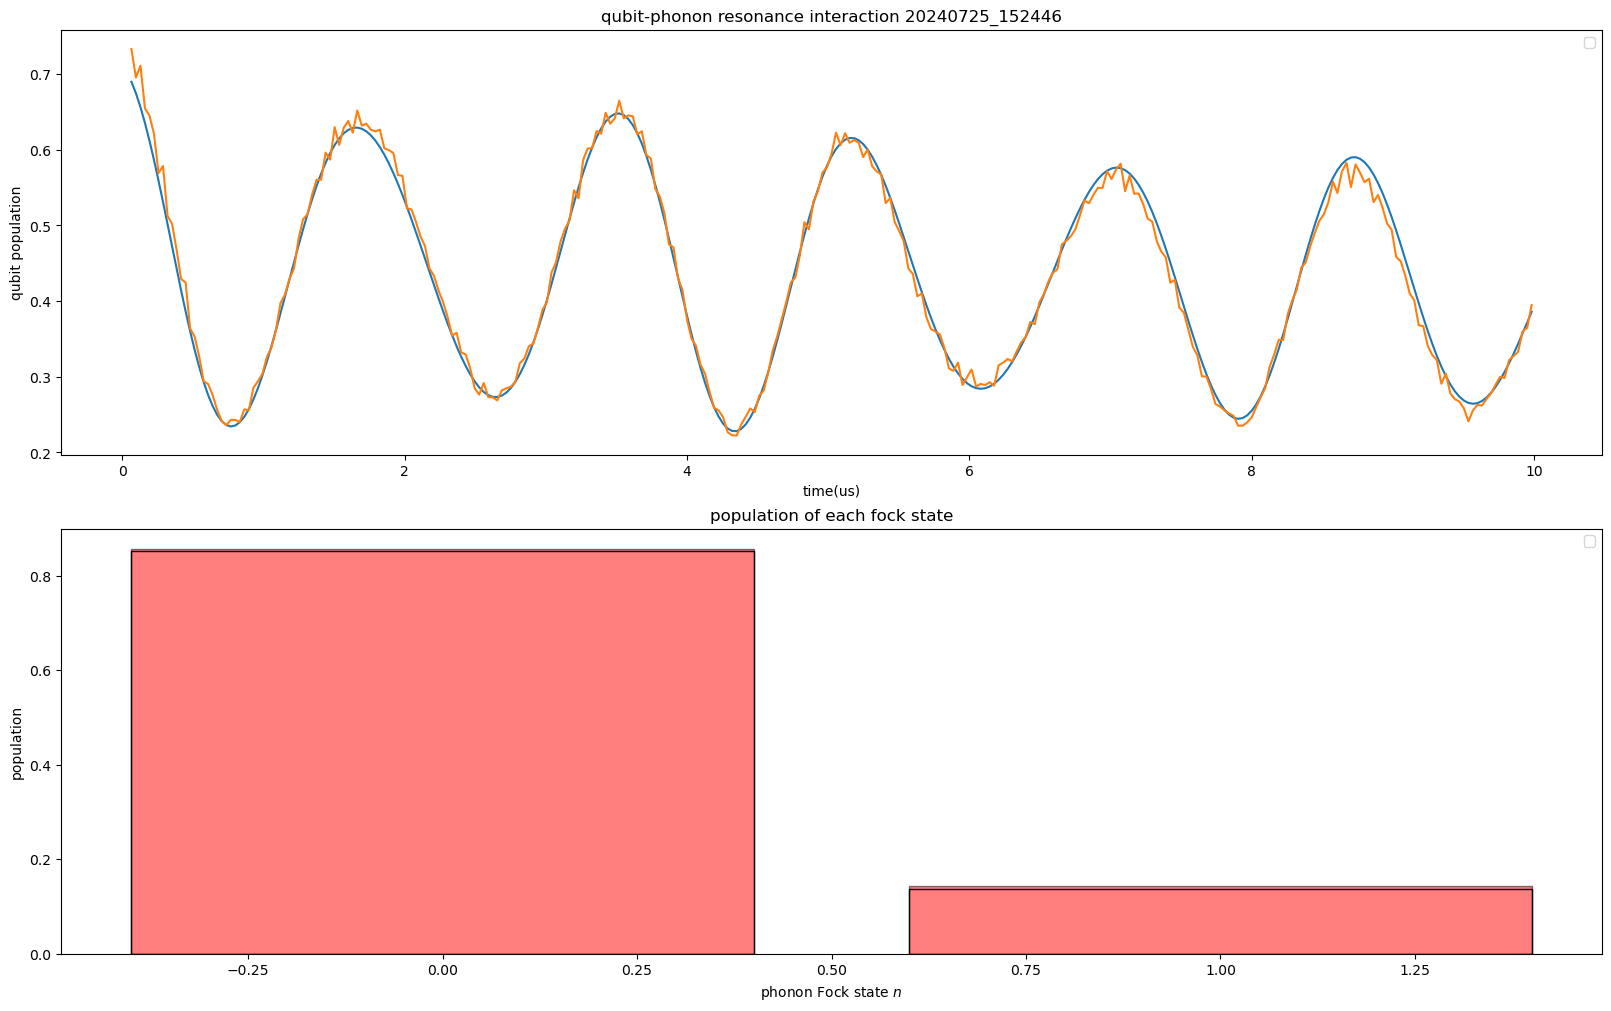

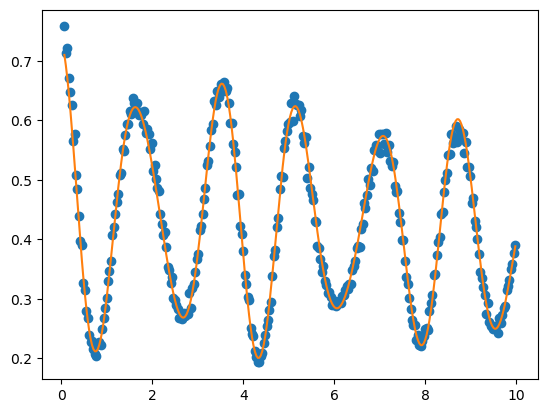

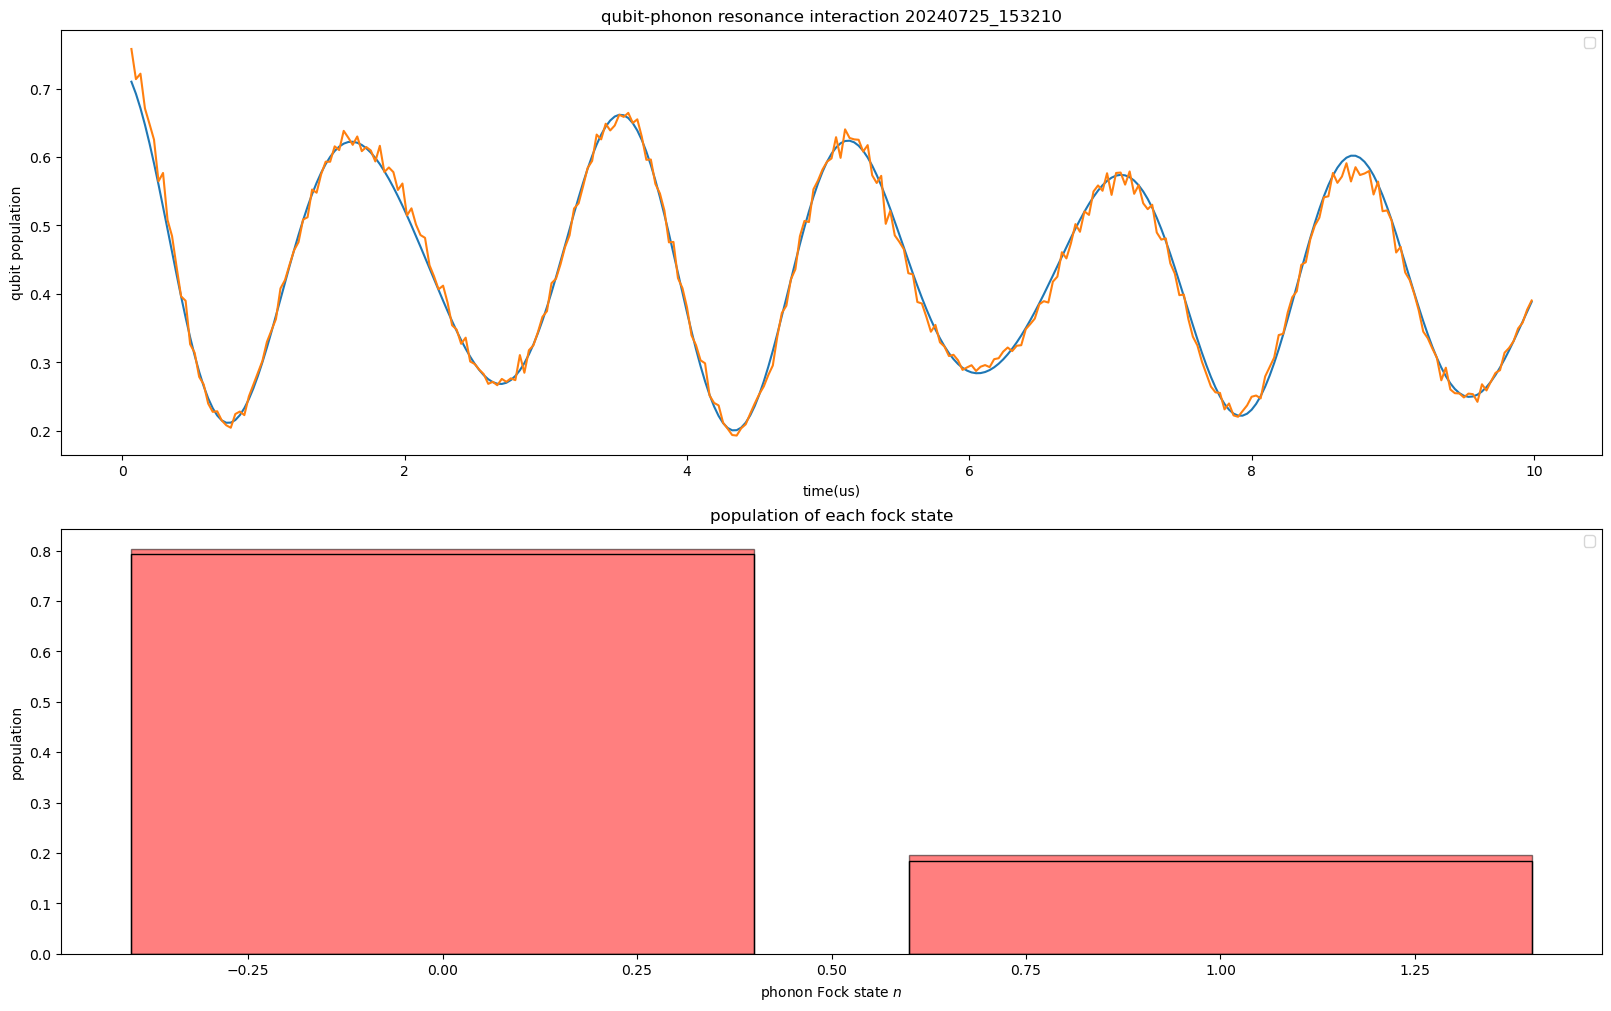

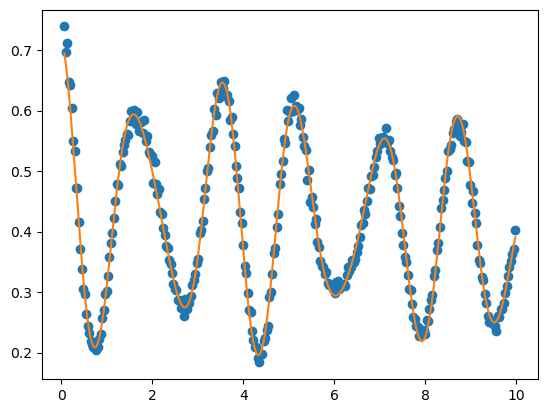

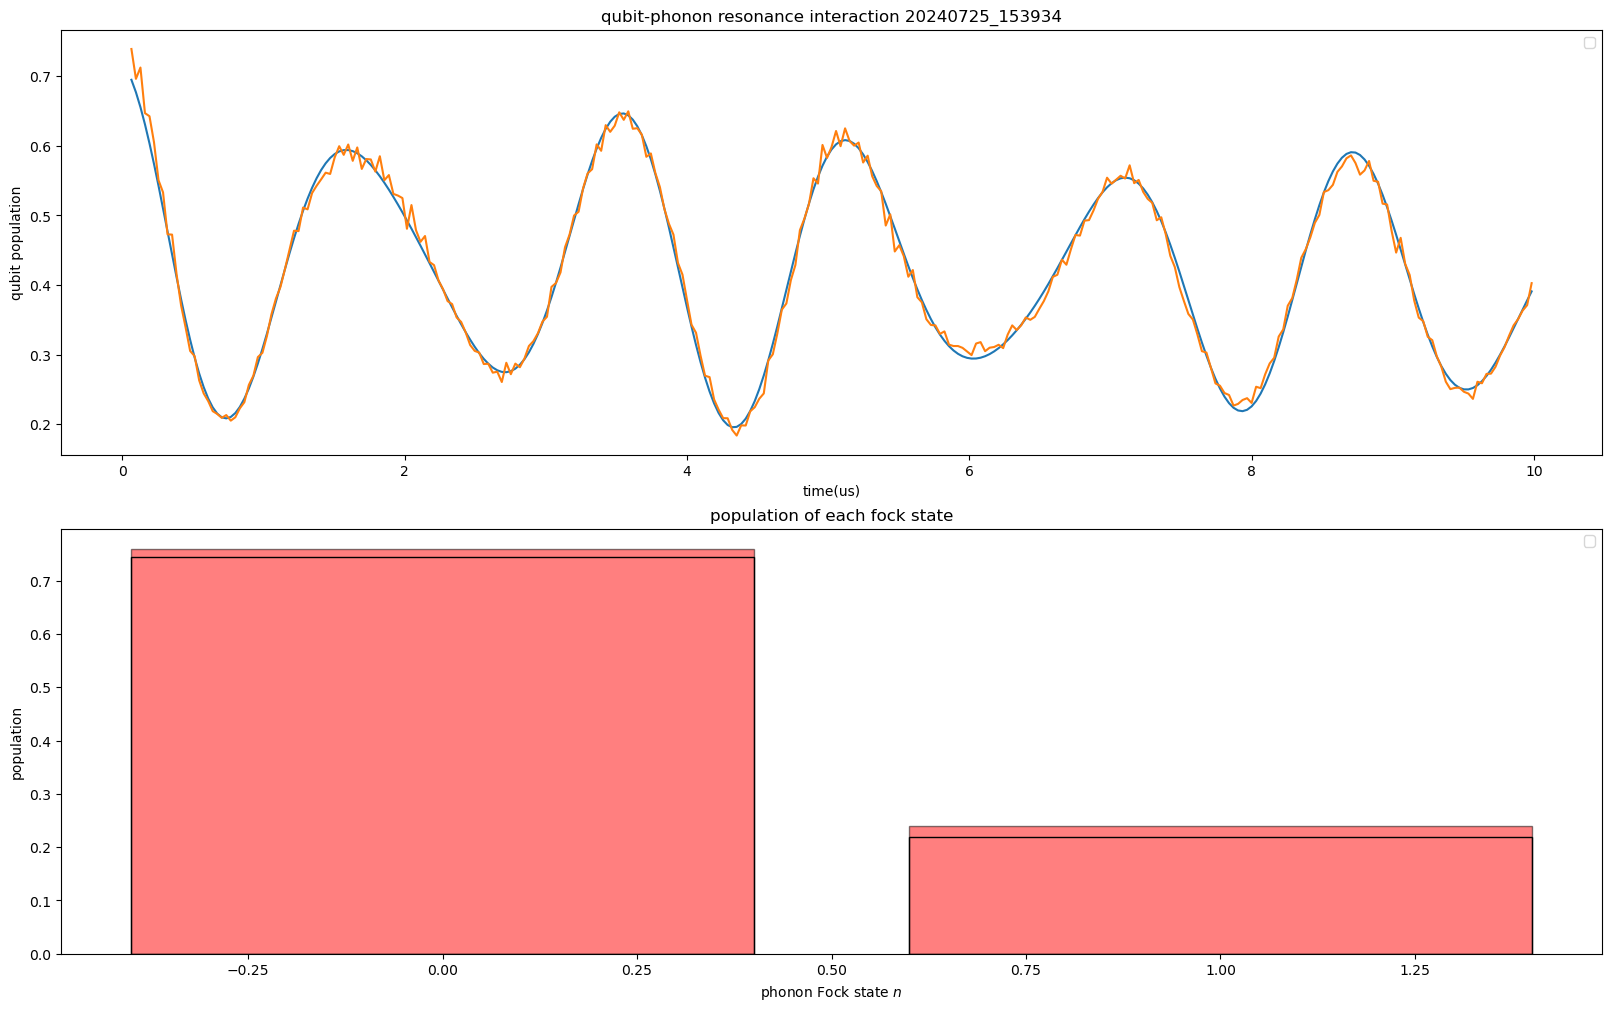

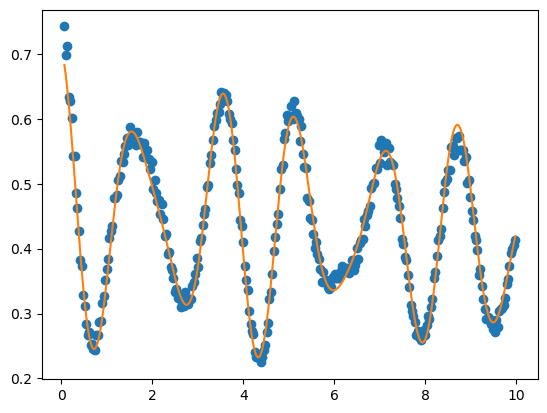

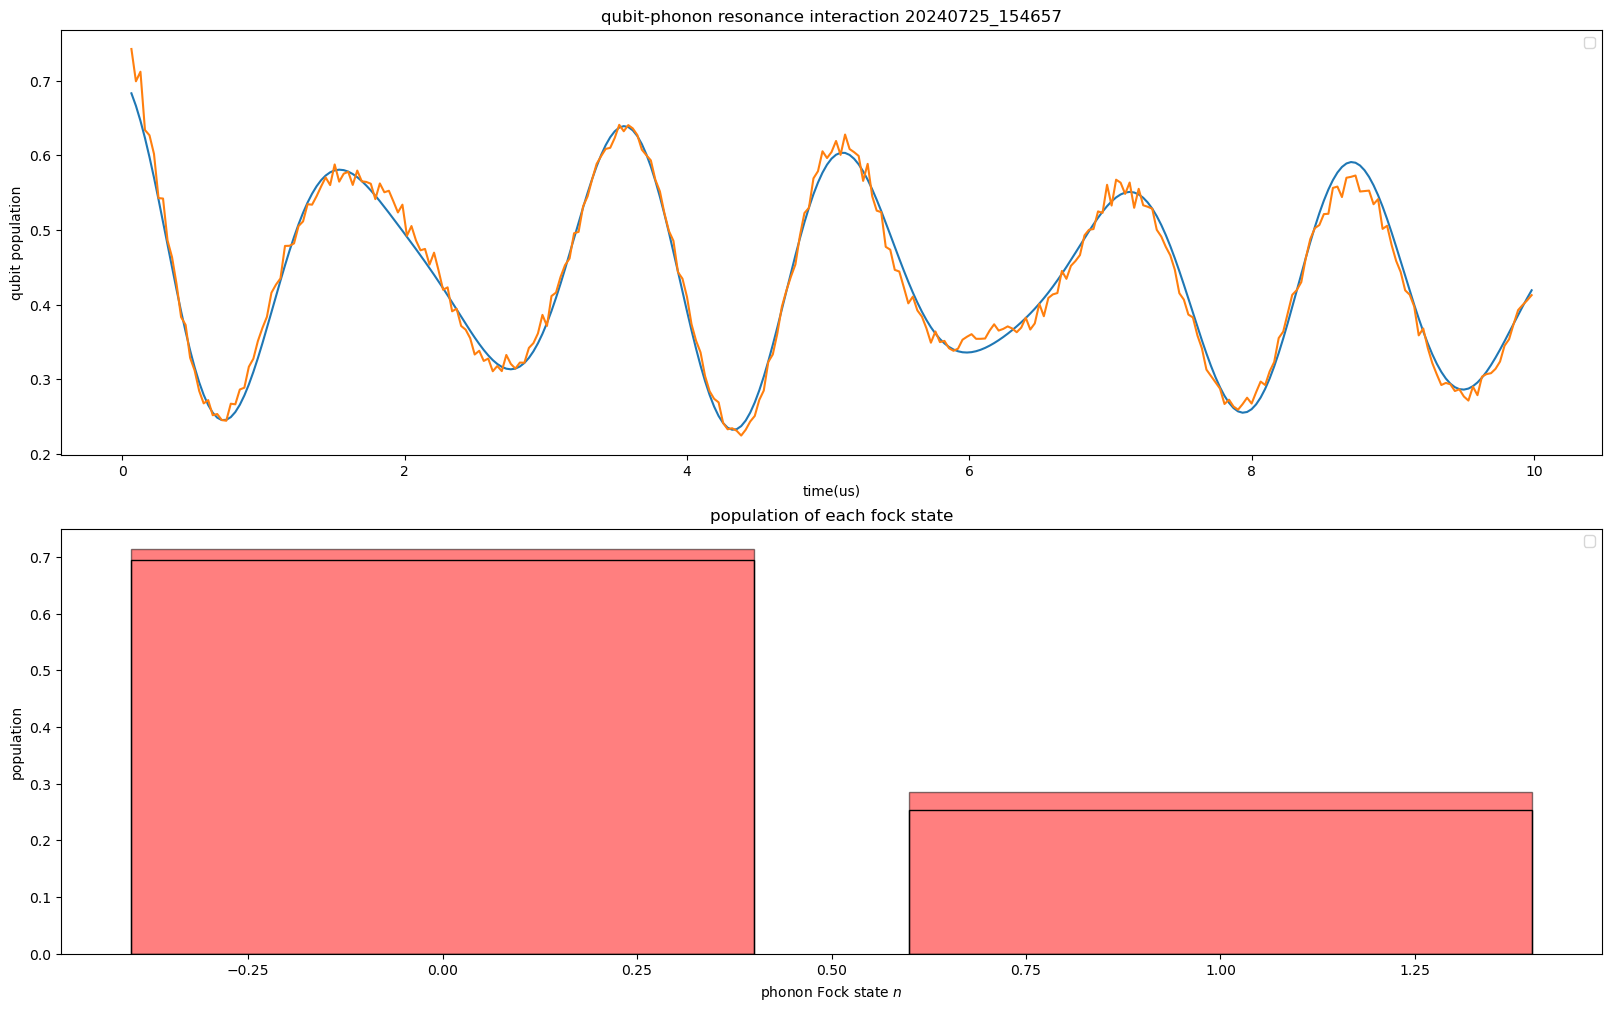

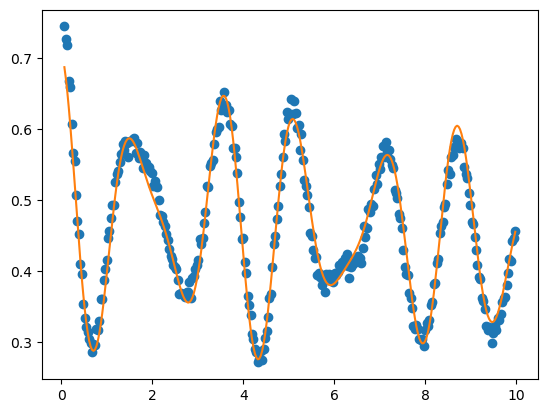

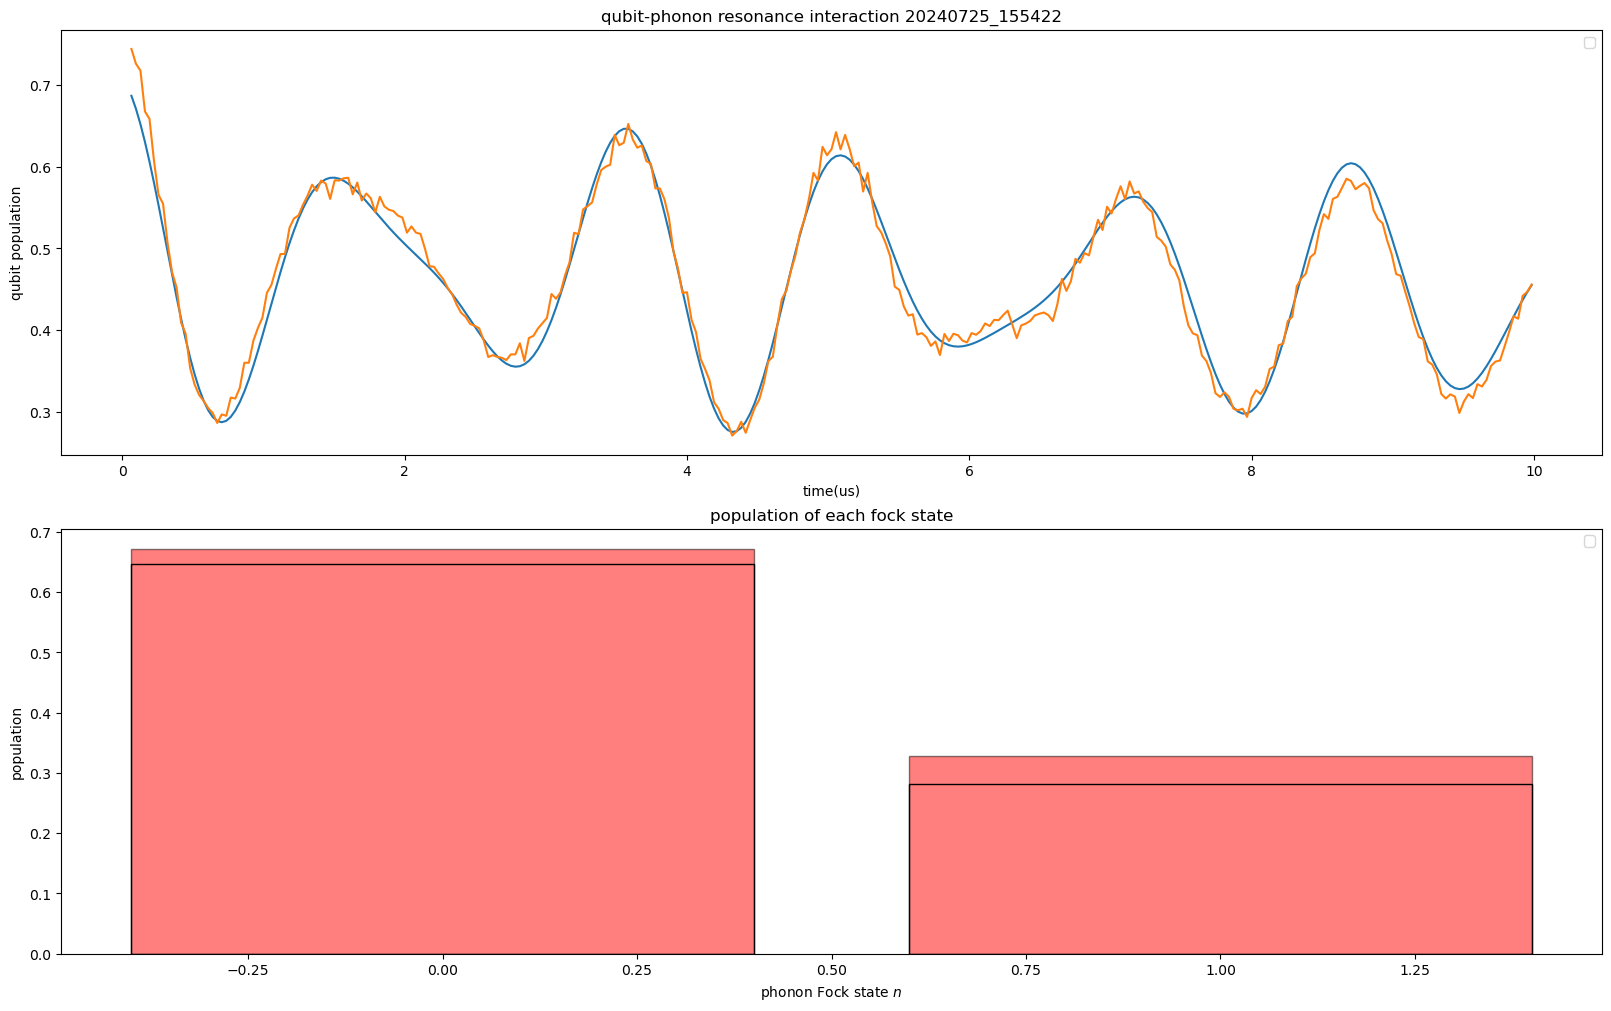

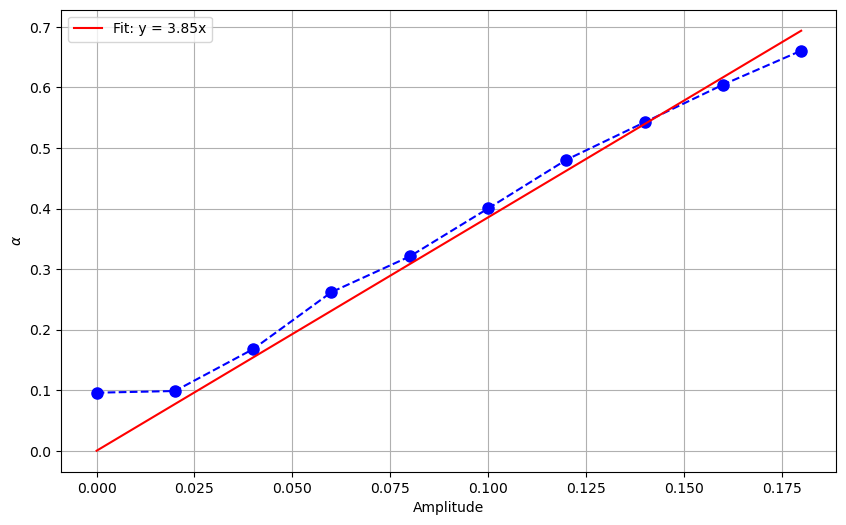

Gradient (slope): 3.854273867387671
Y-intercept: 0 (fixed)


In [3]:
# Fock 0
h5filename = '20240702_optimal_control.h5'
start_time = '20240725_144745'
end_time = '20240725_155422'
g = 0.284
T1q = 22
T2q = 20
T1p = 109.51
maxtime = 10
target_fock = 0
target_basis = target_fock + 2
amps = np.arange(0.00, 0.2, 0.02) # Displacement amps from calibration

# Usage
# process_files(h5filename, start_time, end_time, target_fock, target_basis, amps, g, T1q, T2q, T1p, maxtime, truncate=False, initial_guess=False)
process_files(h5filename, start_time, end_time, target_fock, target_basis, amps, g, T1q, T2q, T1p, maxtime, truncate=True, initial_guess=True)

In [4]:
def calculate_B(p, q):
    if len(p) != len(q):
        raise ValueError("The two distributions must have the same length.")
    B = np.sum(np.sqrt(np.array(p) * np.array(q)))
    return B

def get_datasets_between_timestamps(h5filename, start_time, end_time):
    with h5.File(h5filename, 'r') as f:
        datasets = list(f.keys())
    filtered_datasets = [ds for ds in datasets if start_time <= ds <= end_time]
    return filtered_datasets

def truncate_data(data, max_time=10):
    mask = data[0] <= max_time
    return np.array([data[0][mask], data[1][mask]])

def read_1D_data(file_name, h5filename):
    with h5.File(h5filename, 'r') as f:
        dataset = f[file_name]
        return np.array([dataset['xdata'][:], dataset['ydata'][:]])

def fit_qubit_phonon_interaction_normalization(data, g, T1_q, T2_q_pure, T1_p, target_basis):
    xdata = data[0]
    ydata = data[1]

    def Fock_n_Rabi(g, T1_q, T2_q_pure, T1_p, t_list, Fock_num):
        gamma1_q = 1 / T1_q
        gamma2_q = 1 / T2_q_pure
        gamma1_p = 1 / T1_p
        qubit_dim = 2
        phonon_dim = Fock_num + 2
        q_en = tensor(num(qubit_dim), qeye(phonon_dim))
        swap = tensor(destroy(qubit_dim), create(phonon_dim))
        q_ani = tensor(destroy(qubit_dim), qeye(phonon_dim))
        p_ani = tensor(qeye(qubit_dim), destroy(phonon_dim))
        H_JC = 2 * np.pi * (g * swap + g * swap.dag())
        H_tot = H_JC
        c_ops = [np.sqrt(gamma1_q) * q_ani, np.sqrt(gamma2_q) * q_en, np.sqrt(gamma1_p) * p_ani]
        initial_state = tensor(fock(qubit_dim, 1), fock(phonon_dim, Fock_num))
        result = mesolve(H_tot, initial_state, t_list, c_ops, [q_en])
        return result.expect[0]

    time_data = xdata + 0.05
    time_data = np.insert(time_data, 0, 0)
    simulated_y = Fock_n_Rabi(g, T1_q, T2_q_pure, T1_p, time_data, 0)[1:]

    def objective(params):
        a, b = params
        return np.sum(np.square(a * simulated_y + b - ydata))

    initial_guess = [1, 1]
    result = minimize(objective, initial_guess)
    a_optimized, b_optimized = result.x
    basis_list = [Fock_n_Rabi(g, T1_q, T2_q_pure, T1_p, time_data, i)[1:] for i in range(target_basis)]
    return a_optimized, b_optimized, np.array(basis_list)

def square_sum(g, target, basis):
    summation = g[-2] * np.dot(g[:-2], basis) + g[-1]
    return np.sum(np.square(target - summation))

def plot_fitting(x_data, target_data, file_name, a, b, basis_list, target_basis, initial_guess=None):
    fitted_basis = basis_list[:target_basis]
    bounds = [(0, 1) for _ in range(target_basis)] + [(None, None), (None, None)]
    const = LinearConstraint(np.array([1] * target_basis + [0] + [0]), 1, 1)

    if initial_guess is None:
        x0 = [0] * target_basis + [0] + [0]
    else:
        x0 = initial_guess + [0, 0]

    result = minimize(square_sum, x0=x0, bounds=bounds, constraints=const, args=(target_data, fitted_basis))
    se_value = square_sum(result.x, target_data, fitted_basis)
    fitted_population = result.x[:-2] / np.sum(result.x[:-2])
    a = result.x[-2]
    b = result.x[-1]

#     plt.figure()
#     plt.plot(x_data, target_data, 'o', label='data')
#     plt.plot(x_data, a * np.dot(fitted_population, fitted_basis) + b, label='fit')

#     figure, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), gridspec_kw={'height_ratios': [1, 1]}, constrained_layout=True)
#     ax1.set_xlabel('time(us)')
#     ax1.set_ylabel('qubit population')
#     ax1.legend()
#     ax2.set_xlabel(r'phonon Fock state $n$')
#     ax2.set_ylabel('population')
#     ax2.legend()
#     ax1.plot(x_data, a * np.dot(fitted_population, fitted_basis) + b, label='fitted')
#     ax1.plot(x_data, target_data, label='experiment')
#     ax2.bar(range(target_basis), fitted_population, alpha=0.5, color='r', edgecolor='black', label='fitted from experiment')
#     ax1.set_title('qubit-phonon resonance interaction ' + file_name)
#     ax2.set_title('population of each fock state')
    return fitted_population, se_value, a, b

def process_files_with_theta(h5filename, start_time, end_time, target_fock, target_basis, amps, g, T1q, T2q, T1p, gradient, intercept, maxtime=10, truncate=False, initial_guess=False):
    file_name_list = get_datasets_between_timestamps(h5filename, start_time, end_time)

    previous_distribution = None
    previous_alpha = None
    theta_values = []
    B_values = []

    for i, file_name in enumerate(file_name_list):
        data = read_1D_data(file_name, h5filename)
        if truncate:
            data = truncate_data(data, max_time=maxtime)
        a, b, basis_list = fit_qubit_phonon_interaction_normalization(data, g, T1q, T2q, T1p, target_basis)

        initial_guess_vector = None
        if initial_guess:
            initial_guess_vector = [0] * target_basis
            initial_guess_vector[target_fock] = 1

        fitted_population, se_value, a, b = plot_fitting(data[0], data[1], file_name, a, b, basis_list, target_basis, initial_guess=initial_guess_vector)
        current_alpha = gradient * amps[i] + intercept

        if previous_distribution is not None:
            theta_diff = current_alpha - previous_alpha
            B = calculate_B(previous_distribution, fitted_population)
            theta_values.append(theta_diff)
            B_values.append(B)

        previous_distribution = fitted_population
        previous_alpha = current_alpha

    theta_values = np.array(theta_values)
    B_values = np.array(B_values)
    parameter_values = (1 / theta_values**2) * np.arccos(B_values)**2

    plt.figure(figsize=(10, 6))
    plt.plot(theta_values, parameter_values, 'o--', color='blue', markersize=8)
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$\frac{1}{\theta^2} \arccos^2(B)$')
    plt.title('')
    plt.grid()
    plt.show()
    
def process_files_with_alpha_1(h5filename, start_time, end_time, target_fock, target_basis, amps, g, T1q, T2q, T1p, gradient, intercept, maxtime=10, truncate=False, initial_guess=False):
    file_name_list = get_datasets_between_timestamps(h5filename, start_time, end_time)

    population_array = []
    previous_distribution = None
    previous_alpha = None
    alpha_values = []
    B_values = []

    for i, file_name in enumerate(file_name_list):
        data = read_1D_data(file_name, h5filename)
        if truncate:
            data = truncate_data(data, max_time=maxtime)
        a, b, basis_list = fit_qubit_phonon_interaction_normalization(data, g, T1q, T2q, T1p, target_basis)

        initial_guess_vector = None
        if initial_guess:
            initial_guess_vector = [0] * target_basis
            initial_guess_vector[target_fock] = 1

        fitted_population, se_value, a, b = plot_fitting(data[0], data[1], file_name, a, b, basis_list, target_basis, initial_guess=initial_guess_vector)
        population_array.append(fitted_population)
        current_alpha = gradient * amps[i] + intercept

        if previous_distribution is not None:
            B = calculate_B(previous_distribution, fitted_population)
            alpha_values.append(current_alpha)
            B_values.append(B)

        previous_distribution = fitted_population
        previous_alpha = current_alpha

    alpha_values = np.array(alpha_values)
    B_values = np.array(B_values)
    parameter_values = (1 / (alpha_values**2)) * np.arccos(B_values)**2
    print(population_array)

    plt.figure(figsize=(10, 6))
    plt.plot(alpha_values, parameter_values, 'o--', color='blue', markersize=8)
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$\frac{1}{\alpha^2} \arccos^2(B)$')
    plt.title('')
    plt.grid()
    plt.show()
    
def process_files_with_alpha_2(h5filename, start_time, end_time, target_fock, target_basis, amps, g, T1q, T2q, T1p, gradient, intercept, maxtime=10, truncate=False, initial_guess=False):
    file_name_list = get_datasets_between_timestamps(h5filename, start_time, end_time)

    previous_distribution = None
    previous_alpha = None
    alpha_values = []
    parameter_values = []

    for i, file_name in enumerate(file_name_list):
        data = read_1D_data(file_name, h5filename)
        if truncate:
            data = truncate_data(data, max_time=maxtime)
        a, b, basis_list = fit_qubit_phonon_interaction_normalization(data, g, T1q, T2q, T1p, target_basis)

        initial_guess_vector = None
        if initial_guess:
            initial_guess_vector = [0] * target_basis
            initial_guess_vector[target_fock] = 1

        fitted_population, se_value, a, b = plot_fitting(data[0], data[1], file_name, a, b, basis_list, target_basis, initial_guess=initial_guess_vector)
        current_alpha = gradient * amps[i] + intercept

        if previous_distribution is not None:
            theta_diff = current_alpha - previous_alpha
            B = calculate_B(previous_distribution, fitted_population)
            parameter_value = (1 / theta_diff**2) * np.arccos(B)**2
            alpha_values.append(current_alpha)
            parameter_values.append(parameter_value)

        previous_distribution = fitted_population
        previous_alpha = current_alpha

    alpha_values = np.array(alpha_values)
    parameter_values = np.array(parameter_values)

    plt.figure(figsize=(10, 6))
    plt.plot(alpha_values, parameter_values, 'o--', color='blue', markersize=8)
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$\frac{1}{\theta^2} \arccos^2(B)$')
    plt.title('')
    plt.grid()
    plt.show()

In [5]:
gradient = 3.854273867387671
intercept = 0

# Fock 0

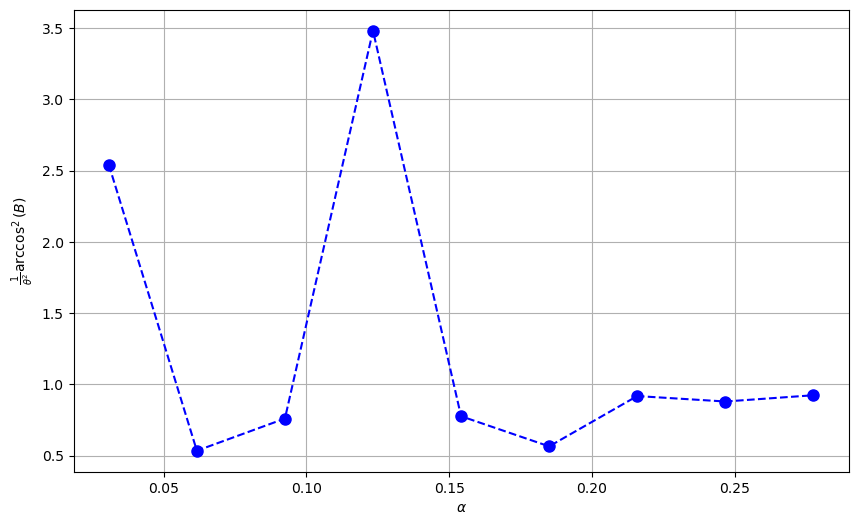

In [6]:
h5filename = '20240702_optimal_control.h5'
start_time = '20240726_093855'
end_time = '20240726_112527'
g = 0.284
T1q = 22
T2q = 20
T1p = 94.61
maxtime = 10
target_fock = 0
target_basis = target_fock + 2
amps = np.arange(0.00, 0.08, 0.008) # Displacement amps

# Usage
# process_files_with_alpha_1(h5filename, start_time, end_time, target_fock, target_basis, amps, g, T1q, T2q, T1p, gradient, intercept, maxtime, truncate=True, initial_guess=True)
process_files_with_alpha_2(h5filename, start_time, end_time, target_fock, target_basis, amps, g, T1q, T2q, T1p, gradient, intercept, maxtime, truncate=True, initial_guess=True)

# Fock 2

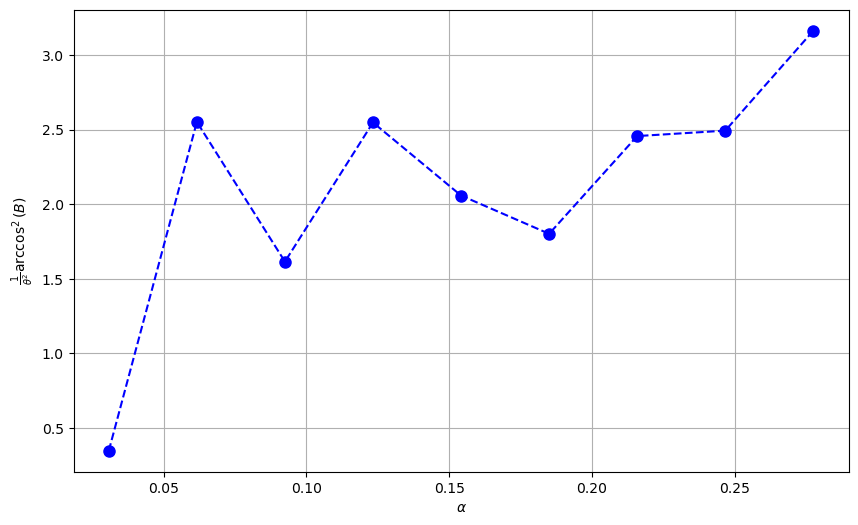

In [7]:
h5filename = '20240702_optimal_control.h5'
start_time = '20240725_161722'
end_time = '20240725_180350'
g = 0.284
T1q = 22
T2q = 20
T1p = 94.61
maxtime = 10
target_fock = 2
target_basis = target_fock + 2
amps = np.arange(0.00, 0.08, 0.008) # Displacement amps

# Usage
# process_files_with_alpha_1(h5filename, start_time, end_time, target_fock, target_basis, amps, g, T1q, T2q, T1p, gradient, intercept, maxtime, truncate=True, initial_guess=True)
process_files_with_alpha_2(h5filename, start_time, end_time, target_fock, target_basis, amps, g, T1q, T2q, T1p, gradient, intercept, maxtime, truncate=True, initial_guess=True)

# Fock 3

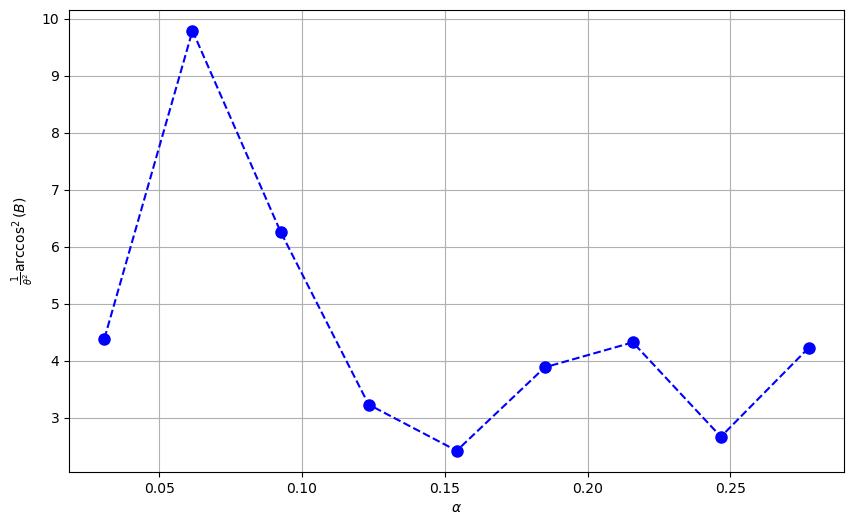

In [8]:
h5filename = '20240702_optimal_control.h5'
start_time = '20240725_181541'
end_time = '20240725_200228'
g = 0.284
T1q = 22
T2q = 20
T1p = 94.61
maxtime = 10
target_fock = 3
target_basis = target_fock + 2
amps = np.arange(0.00, 0.08, 0.008) # Displacement amps

# Usage
# process_files_with_alpha_1(h5filename, start_time, end_time, target_fock, target_basis, amps, g, T1q, T2q, T1p, gradient, intercept, maxtime, truncate=True, initial_guess=True)
process_files_with_alpha_2(h5filename, start_time, end_time, target_fock, target_basis, amps, g, T1q, T2q, T1p, gradient, intercept, maxtime, truncate=True, initial_guess=True)

# Fock 4

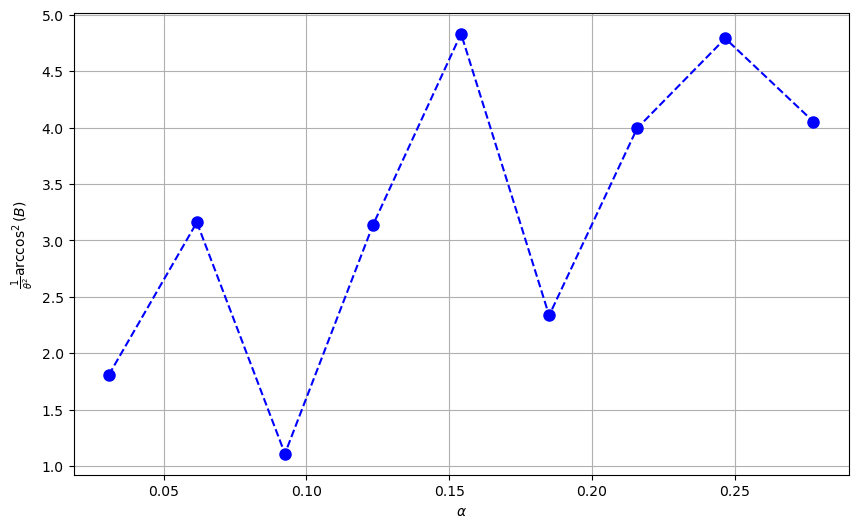

In [9]:
h5filename = '20240702_optimal_control.h5'
start_time = '20240725_201419'
end_time = '20240725_220118'
g = 0.284
T1q = 22
T2q = 20
T1p = 94.61
maxtime = 10
target_fock = 4
target_basis = target_fock + 2
amps = np.arange(0.00, 0.08, 0.008) # Displacement amps

# Usage
# process_files_with_alpha_1(h5filename, start_time, end_time, target_fock, target_basis, amps, g, T1q, T2q, T1p, gradient, intercept, maxtime, truncate=True, initial_guess=True)
process_files_with_alpha_2(h5filename, start_time, end_time, target_fock, target_basis, amps, g, T1q, T2q, T1p, gradient, intercept, maxtime, truncate=True, initial_guess=True)

# Fock 5

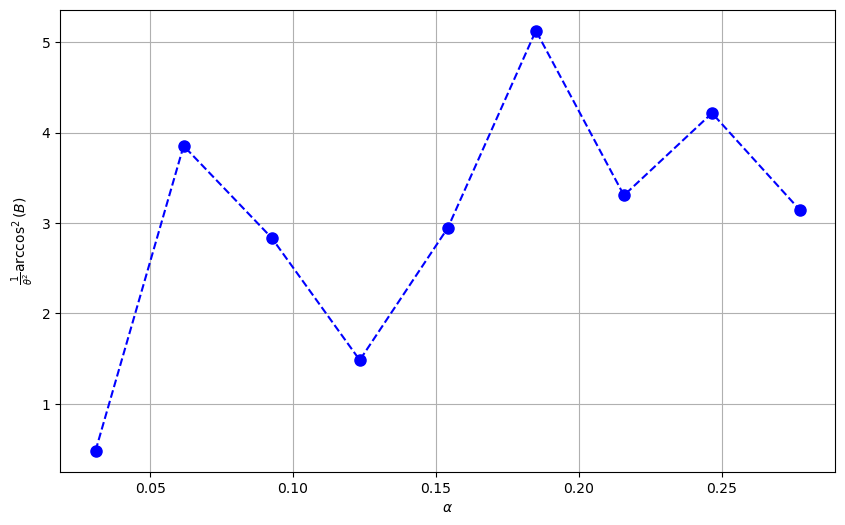

In [10]:
h5filename = '20240702_optimal_control.h5'
start_time = '20240725_221311'
end_time = '20240726_000020'
g = 0.284
T1q = 22
T2q = 20
T1p = 94.61
maxtime = 10
target_fock = 5
target_basis = target_fock + 2
amps = np.arange(0.00, 0.08, 0.008) # Displacement amps

# Usage
# process_files_with_alpha_1(h5filename, start_time, end_time, target_fock, target_basis, amps, g, T1q, T2q, T1p, gradient, intercept, maxtime, truncate=True, initial_guess=True)
process_files_with_alpha_2(h5filename, start_time, end_time, target_fock, target_basis, amps, g, T1q, T2q, T1p, gradient, intercept, maxtime, truncate=True, initial_guess=True)

# Fock 6

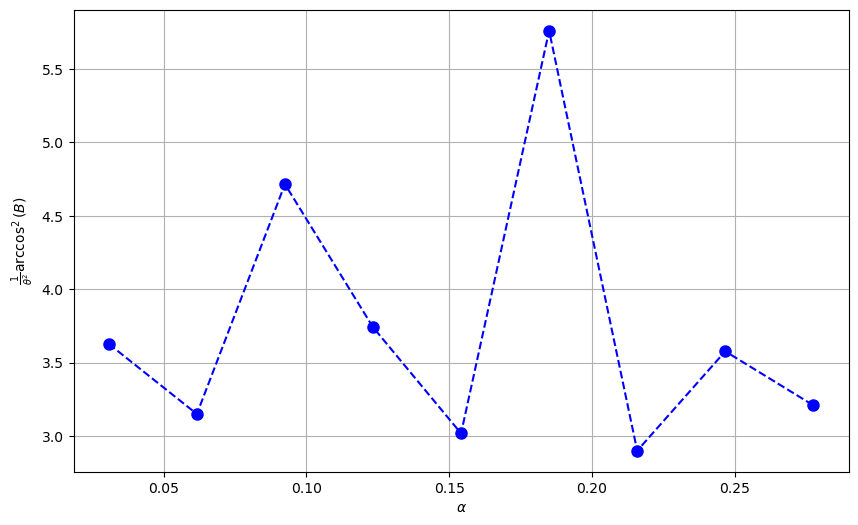

In [11]:
h5filename = '20240702_optimal_control.h5'
start_time = '20240726_001215'
end_time = '20240726_015932'
g = 0.284
T1q = 22
T2q = 20
T1p = 94.61
maxtime = 10
target_fock = 6
target_basis = target_fock + 2
amps = np.arange(0.00, 0.08, 0.008) # Displacement amps

# Usage
# process_files_with_alpha_1(h5filename, start_time, end_time, target_fock, target_basis, amps, g, T1q, T2q, T1p, gradient, intercept, maxtime, truncate=True, initial_guess=True)
process_files_with_alpha_2(h5filename, start_time, end_time, target_fock, target_basis, amps, g, T1q, T2q, T1p, gradient, intercept, maxtime, truncate=True, initial_guess=True)

# Fock 7

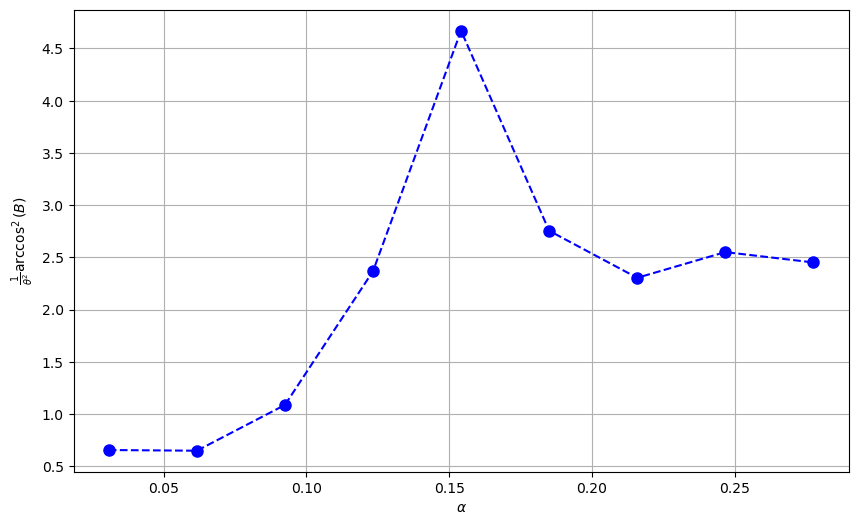

In [12]:
h5filename = '20240702_optimal_control.h5'
start_time = '20240726_021128'
end_time = '20240726_035854'
g = 0.284
T1q = 22
T2q = 20
T1p = 94.61
maxtime = 10
target_fock = 7
target_basis = target_fock + 2
amps = np.arange(0.00, 0.08, 0.008) # Displacement amps

# Usage
# process_files_with_alpha_1(h5filename, start_time, end_time, target_fock, target_basis, amps, g, T1q, T2q, T1p, gradient, intercept, maxtime, truncate=True, initial_guess=True)
process_files_with_alpha_2(h5filename, start_time, end_time, target_fock, target_basis, amps, g, T1q, T2q, T1p, gradient, intercept, maxtime, truncate=True, initial_guess=True)

In [13]:
def displacement_operator(fock_state_distribution, alpha):
    max_n = len(fock_state_distribution)
    new_distribution = np.zeros(max_n, dtype=complex)
    for m in range(max_n):
        displaced_amplitude = 0
        for n in range(max_n):
            if n < m:
                term = (alpha ** (m - n) * np.sqrt(np.math.factorial(n) / np.math.factorial(m)) *
                        eval_genlaguerre(n, m - n, np.abs(alpha) ** 2) * np.exp(-0.5 * np.abs(alpha) ** 2))
            else:
                term = (np.conj(alpha) ** (n - m) * np.sqrt(np.math.factorial(m) / np.math.factorial(n)) *
                        eval_genlaguerre(m, n - m, np.abs(alpha) ** 2) * np.exp(-0.5 * np.abs(alpha) ** 2))
            displaced_amplitude += term * fock_state_distribution[n]
        new_distribution[m] = displaced_amplitude
    return new_distribution

def compute_final_value(initial_state, alpha, dim_phonon):
    initial_density_matrix = initial_state * initial_state.dag()
    displacement_operator = qt.displace(dim_phonon, alpha)
    final_density_matrix = displacement_operator * initial_density_matrix * displacement_operator.dag()
    
    # Extract population distributions from density matrices
    initial_distribution = np.abs(initial_density_matrix.diag()) / np.sum(np.abs(initial_density_matrix.diag()))
    final_distribution = np.abs(final_density_matrix.diag()) / np.sum(np.abs(final_density_matrix.diag()))
    
    B_value = calculate_B(initial_distribution, final_distribution)
    term1 = np.arccos(B_value)**2
    term2 = 1/((alphas[1] - alphas[0])**2)
    return term1 * term2

In [14]:
dim_phonon = 11
alphas = np.arange(0.001, 0.1, 0.001)

plt.figure(figsize=(10, 6))

for fock_state in range(8):
    final_values = []
    populations = [1 if n == fock_state else 0 for n in range(dim_phonon)]
    
    initial_state_small = sum(np.sqrt(pop) * qt.basis(dim_phonon, n) for n, pop in enumerate(populations))
    initial_state = qt.Qobj(np.pad(initial_state_small.full(), [(0, dim_phonon - len(populations)), (0, 0)]))
    initial_state = initial_state.unit()
    
    for alpha in alphas:
        final_value = compute_final_value(initial_state, alpha, dim_phonon)
        final_values.append(final_value)
    
#     plt.plot(alphas, final_values, label=f'Fock {fock_state}')

# plt.xlabel(r'$\alpha$')
# plt.ylabel(r'$\frac{1}{\theta^2} \arccos^2 B$')
# plt.title('')
# plt.legend()
# plt.grid(True)
# plt.show()

<Figure size 1000x600 with 0 Axes>

# Simulate QFI and R for Ideal and Measured Starting Distributions

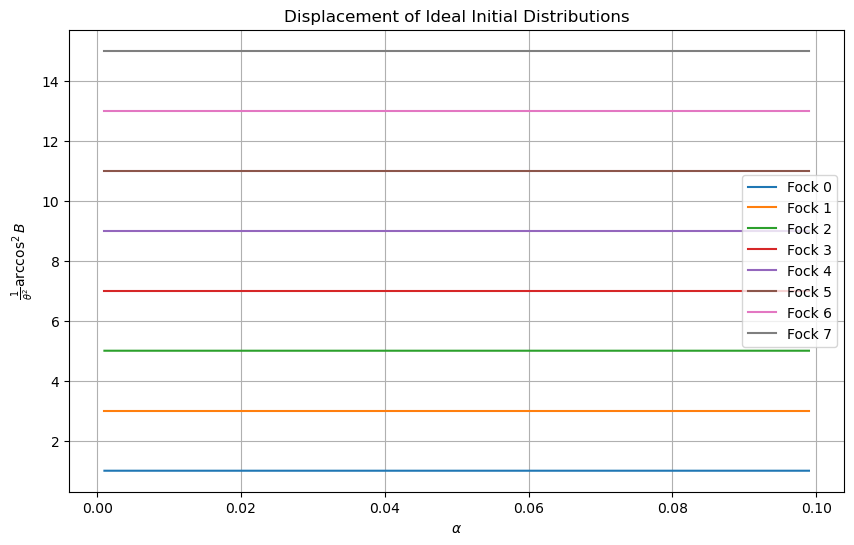

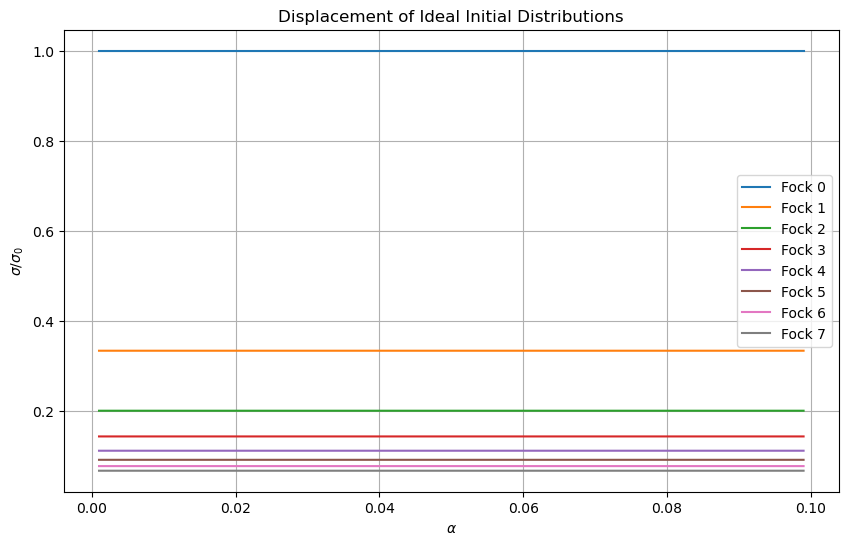

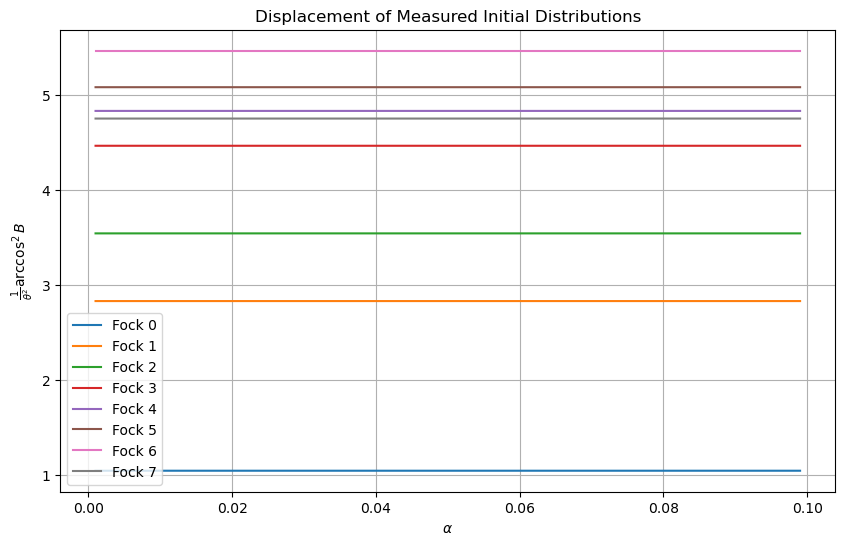

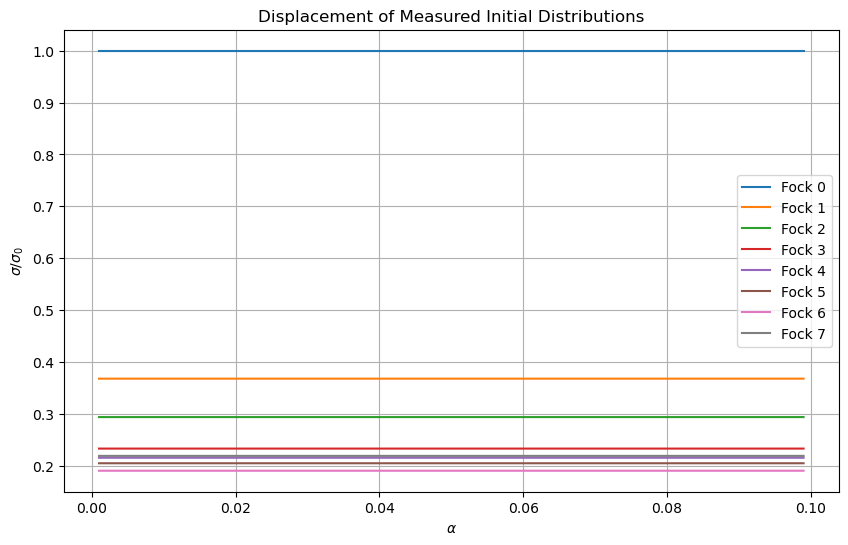

In [15]:
# Plotting y/y_0 as well

def compute_final_value(initial_state, alpha_values, dim_phonon):
    initial_density_matrix = initial_state * initial_state.dag()
    initial_distribution = np.abs(initial_density_matrix.diag()) / np.sum(np.abs(initial_density_matrix.diag()))
    
    previous_distribution = initial_distribution
    final_values = []
    
    for alpha in alpha_values:
        displacement_op = qt.displace(dim_phonon, alpha)
        final_density_matrix = displacement_op * initial_density_matrix * displacement_op.dag()
        
        final_distribution = np.abs(final_density_matrix.diag()) / np.sum(np.abs(final_density_matrix.diag()))
        
        B_value = calculate_B(previous_distribution, final_distribution)
        term1 = np.arccos(B_value)**2
        term2 = 1/((alpha_values[1] - alpha_values[0])**2)
        
        final_value = term1 * term2
        final_values.append(final_value)
        
        # Update previous_distribution to be the current final_distribution
        previous_distribution = final_distribution
    
    return final_values

def plot_normalized_final_values(fock_distributions, title, dim_phonon=11, alpha_max=0.1, alpha_step=0.01):
    
    initial_state_small_0 = sum(np.sqrt(pop) * qt.basis(dim_phonon, n) for n, pop in enumerate(fock_distributions[0]))
    initial_state_0 = qt.Qobj(np.pad(initial_state_small_0.full(), [(0, dim_phonon - len(fock_distributions[0])), (0, 0)]))
    initial_state_0 = initial_state_0.unit()
    
    sigma_0_values = compute_final_value(initial_state_0, alphas, dim_phonon)
    
    plt.figure(figsize=(10, 6))
    
    for fock_state, populations in enumerate(fock_distributions):
        initial_state_small = sum(np.sqrt(pop) * qt.basis(dim_phonon, n) for n, pop in enumerate(populations))
        initial_state = qt.Qobj(np.pad(initial_state_small.full(), [(0, dim_phonon - len(populations)), (0, 0)]))
        initial_state = initial_state.unit()
        
        final_values = compute_final_value(initial_state, alphas, dim_phonon)
        
        normalized_values = [fv / sigma_0_values[i] for i, fv in enumerate(final_values)]
        reciprocal = [1/nv for nv in normalized_values]
        
        plt.plot(alphas, final_values, label=f'Fock {fock_state}')
    
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$\frac{1}{\theta^2} \arccos^2 B$')
    plt.title(f'{title}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plotting ratios of final values to Fock state 0 values
    plt.figure(figsize=(10, 6))
    
    for fock_state, populations in enumerate(fock_distributions):
        if fock_state == 0:
            ratios = [1] * len(alphas)
        else:
            initial_state_small = sum(np.sqrt(pop) * qt.basis(dim_phonon, n) for n, pop in enumerate(populations))
            initial_state = qt.Qobj(np.pad(initial_state_small.full(), [(0, dim_phonon - len(populations)), (0, 0)]))
            initial_state = initial_state.unit()
            
            final_values = compute_final_value(initial_state, alphas, dim_phonon)
            
            ratios = [sigma_0_values[i] / fv for i, fv in enumerate(final_values)]
        
        plt.plot(alphas, ratios, label=f'Fock {fock_state}')
    
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$\sigma / \sigma_0$')
    plt.title(f'{title}')
    plt.grid(True)
    plt.legend()
    plt.show()

fock_distributions_ideal = [
    [1 if n == 0 else 0 for n in range(11)], # Fock state 0
    [1 if n == 1 else 0 for n in range(11)], # Fock state 1
    [1 if n == 2 else 0 for n in range(11)], # Fock state 2
    [1 if n == 3 else 0 for n in range(11)], # Fock state 3
    [1 if n == 4 else 0 for n in range(11)], # Fock state 4
    [1 if n == 5 else 0 for n in range(11)], # Fock state 5
    [1 if n == 6 else 0 for n in range(11)], # Fock state 6
    [1 if n == 7 else 0 for n in range(11)]  # Fock state 7
]

plot_normalized_final_values(fock_distributions_ideal, "Displacement of Ideal Initial Distributions")

# fock_distributions_measured = [
#     [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # Fock 0
#     [0.061, 0.929, 0.010, 0, 0, 0, 0, 0, 0, 0, 0], # Fock 1
#     [0.050, 0.054, 0.893, 0.003, 0, 0, 0, 0, 0, 0, 0], # Fock 2
#     [0.071, 0.048, 0.102, 0.779, 0.000, 0, 0, 0, 0, 0, 0], # Fock 3
#     [0.083, 0.035, 0.045, 0.108, 0.718, 0.011, 0, 0, 0, 0, 0], # Fock 4
#     [0.084, 0.037, 0.043, 0.047, 0.141, 0.632, 0.015, 0, 0, 0, 0], # Fock 5
#     [0.077, 0.072, 0.055, 0.032, 0.043, 0.143, 0.572, 0.005, 0, 0, 0], # Fock 6
#     [0.086, 0.033, 0.020, 0.035, 0.042, 0.049, 0.168, 0.502, 0.065, 0, 0]  # Fock 7
# ]

# plot_normalized_final_values(fock_distributions_measured, "Displacement of Measured Initial Distributions")

fock_distributions_measured = [
    [0.98, 0.02, 0, 0, 0, 0, 0, 0, 0, 0, 0], # Fock 0
    [0.061, 0.929, 0.010, 0, 0, 0, 0, 0, 0, 0, 0], # Fock 1
    [0.07008216409992936, 0.17115246609971194, 0.7480835594520676, 0.010681810348291031, 0, 0, 0, 0, 0, 0, 0], # Fock 2
    [0.08126653173482112, 0.06500186770359377, 0.20793212144366582, 0.6457994791179194, 1.0842021724855044e-19, 0, 0, 0, 0, 0, 0], # Fock 3
    [0.0993473294856583, 0.04115218059246574, 0.07580666341213779, 0.20672055939862072, 0.572293611777418, 0.004679655333699489, 0, 0, 0, 0, 0], # Fock 4
    [0.08298757683289867, 0.037347002859483724, 0.04441669550245825, 0.08927704034817024, 0.2592556838290793, 0.47374616039572, 0.01296984023218982, 0, 0, 0, 0], # Fock 5
    [0.08962878250947301, 0.07908858411429454, 0.05640279465091695, 0.03373307431227458, 0.08433575252188882, 0.25608897331435737, 0.3969373823036862, 0.0037846562731085566, 0, 0, 0], # Fock 6
    [0.0932597401336016, 0.04018363042425707, 0.03718552967523681, 0.045750303848101886, 0.059828783214645444, 0.11117999941938458, 0.2646347019978219, 0.32040232415246417, 0.027574987134486667, 0, 0]  # Fock 7
]

plot_normalized_final_values(fock_distributions_measured, "Displacement of Measured Initial Distributions")

# Plot Ideal and Measured R Together

/tmp/ipykernel_3365216/3285546268.py:41: RuntimeWarning: invalid value encountered in scalar divide
  final_values.append(final_value / sigma_0_values[alphas.tolist().index(alpha)])
/tmp/ipykernel_3365216/3285546268.py:54: RuntimeWarning: invalid value encountered in scalar divide
  ideal_values.append(ideal_value / sigma_0_values[alphas.tolist().index(alpha)])


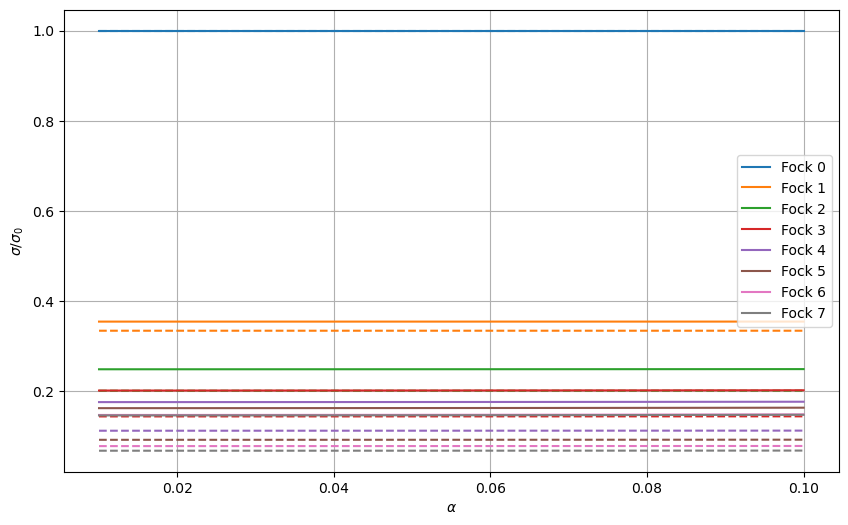

In [16]:
alphas = np.arange(0.001, 0.1, 0.001)

def compute_final_value(initial_state, alpha, dim_phonon):
    initial_density_matrix = initial_state * initial_state.dag()
    displacement_operator = qt.displace(dim_phonon, alpha)
    final_density_matrix = displacement_operator * initial_density_matrix * displacement_operator.dag()
    
    # Extract population distributions from density matrices
    initial_distribution = np.abs(initial_density_matrix.diag()) / np.sum(np.abs(initial_density_matrix.diag()))
    final_distribution = np.abs(final_density_matrix.diag()) / np.sum(np.abs(final_density_matrix.diag()))
    
    B_value = calculate_B(initial_distribution, final_distribution)
    term1 = np.arccos(B_value)**2
    term2 = 1/((alphas[1] - alphas[0])**2)
    return term1 * term2

def plot_normalized_final_values(fock_distributions, dim_phonon=11, alpha_max=0.1, alpha_step=0.01):
    alphas = np.arange(0, alpha_max + alpha_step, alpha_step)
    
    initial_state_small_0 = sum(np.sqrt(pop) * qt.basis(dim_phonon, n) for n, pop in enumerate(fock_distributions[0]))
    initial_state_0 = qt.Qobj(np.pad(initial_state_small_0.full(), [(0, dim_phonon - len(fock_distributions[0])), (0, 0)]))
    initial_state_0 = initial_state_0.unit()
    
    sigma_0_values = []
    for alpha in alphas:
        sigma_0_values.append(compute_final_value(initial_state_0, alpha, dim_phonon))
    
    plt.figure(figsize=(10, 6))
    
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Get default colors

    for fock_state, (populations, color) in enumerate(zip(fock_distributions, colors)):
        final_values = []
        
        initial_state_small = sum(np.sqrt(pop) * qt.basis(dim_phonon, n) for n, pop in enumerate(populations))
        initial_state = qt.Qobj(np.pad(initial_state_small.full(), [(0, dim_phonon - len(populations)), (0, 0)]))
        initial_state = initial_state.unit()
        
        for alpha in alphas:
            final_value = compute_final_value(initial_state, alpha, dim_phonon)
            final_values.append(final_value / sigma_0_values[alphas.tolist().index(alpha)])
            
        reciprocal = [1/final_value for final_value in final_values]
        plt.plot(alphas, reciprocal, label=f'Fock {fock_state}', color=color)
        
        # Plot the ideal lines with dashed style but the same color
        ideal_populations = [1 if n == fock_state else 0 for n in range(dim_phonon)]
        initial_state_ideal = sum(np.sqrt(pop) * qt.basis(dim_phonon, n) for n, pop in enumerate(ideal_populations))
        initial_state_ideal = qt.Qobj(np.pad(initial_state_ideal.full(), [(0, dim_phonon - len(ideal_populations)), (0, 0)])).unit()
        
        ideal_values = []
        for alpha in alphas:
            ideal_value = compute_final_value(initial_state_ideal, alpha, dim_phonon)
            ideal_values.append(ideal_value / sigma_0_values[alphas.tolist().index(alpha)])
        
        ideal_reciprocal = [1/ideal_value for ideal_value in ideal_values]
        plt.plot(alphas, ideal_reciprocal, linestyle='--', color=color)
    
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$\sigma / \sigma_0$')
    plt.title('')
    plt.legend()
    plt.grid(True)
    plt.show()

# Provided distributions
fock_distributions_real = [
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # Fock 0
    [0.061, 0.929, 0.010, 0, 0, 0, 0, 0, 0, 0, 0], # Fock 1
    [0.050, 0.054, 0.893, 0.003, 0, 0, 0, 0, 0, 0, 0], # Fock 2
    [0.071, 0.048, 0.102, 0.779, 0.000, 0, 0, 0, 0, 0, 0], # Fock 3
    [0.083, 0.035, 0.045, 0.108, 0.718, 0.011, 0, 0, 0, 0, 0], # Fock 4
    [0.084, 0.037, 0.043, 0.047, 0.141, 0.632, 0.015, 0, 0, 0, 0], # Fock 5
    [0.077, 0.072, 0.055, 0.032, 0.043, 0.143, 0.572, 0.005, 0, 0, 0], # Fock 6
    [0.086, 0.033, 0.020, 0.035, 0.042, 0.049, 0.168, 0.502, 0.065, 0, 0]  # Fock 7
]

plot_normalized_final_values(fock_distributions_real)

# Plot QFI and R From Displacement Measurements Together

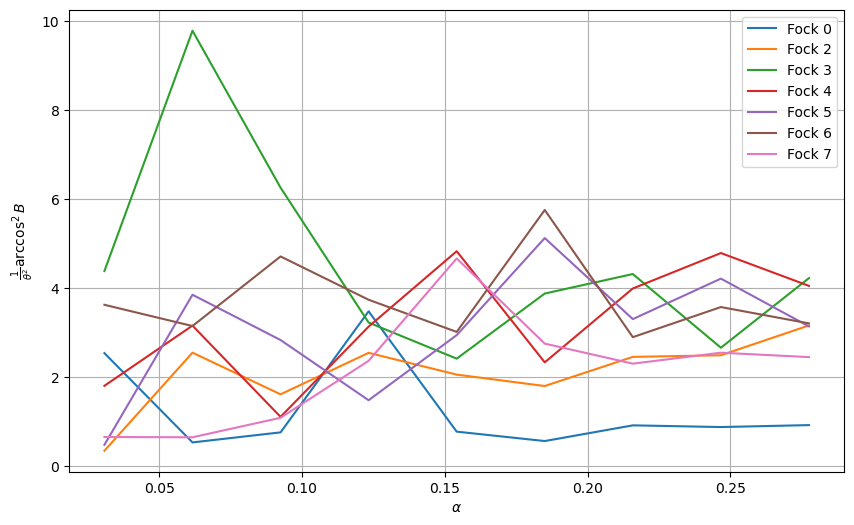

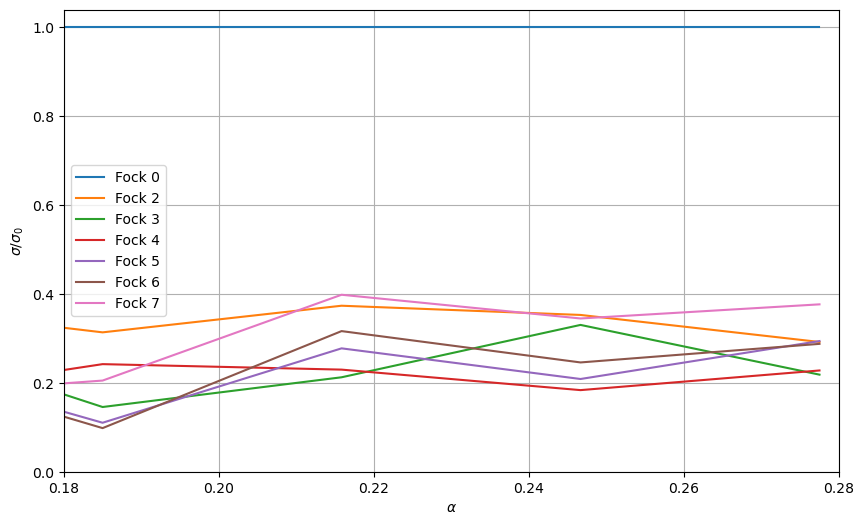

In [17]:
diff = 1 # Distance between neighbors when calculating the Bhattacharyya coefficient 
amps = np.arange(0.00, 0.08, 0.008) # Displacement amps
alphas = [(gradient*amp + intercept) for amp in amps]
alphas = alphas[diff:]

# # Constants
# fock_states_and_times = [
#     (0, '20240717_233536', '20240718_004311'),
#     (2, '20240717_190302', '20240717_194343'),
#     (3, '20240717_194814', '20240717_202901'),
#     (4, '20240717_203333', '20240717_211426'),
#     (5, '20240717_211858', '20240717_215954'),
#     (6, '20240717_220427', '20240717_224527'),
#     (7, '20240717_224959', '20240717_233102')
# ]

# Constants
fock_states_and_times = [
    (0, '20240726_093855', '20240726_112527'),
    (2, '20240725_161722', '20240725_180350'),
    (3, '20240725_181541', '20240725_200228'),
    (4, '20240725_201419', '20240725_220118'),
    (5, '20240725_221311', '20240726_000020'),
    (6, '20240726_001215', '20240726_015932'),
    (7, '20240726_021128', '20240726_035854')
]

h5filename = '20240702_optimal_control.h5'
maxtime = 10
measurement_time = 12
g = 0.284
T1q = 22
T2q = 20
T1p = 94.61

def get_datasets_between_timestamps(h5filename, start_time, end_time):
    with h5.File(h5filename, 'r') as f:
        datasets = list(f.keys())
    filtered_datasets = [ds for ds in datasets if start_time <= ds <= end_time]
    return filtered_datasets

def truncate_data(data, max_time=measurement_time):
    mask = data[0] <= max_time
    return np.array([data[0][mask], data[1][mask]])

def read_1D_data(file_name):
    with h5.File(h5filename, 'r') as f:
        dataset = f[file_name]
        return np.array([dataset['xdata'][:], dataset['ydata'][:]])

def fit_qubit_phonon_interaction_normalization(data, measurement_time, g, T1_q, T2_q_pure, T1_p):
    xdata = data[0]
    ydata = data[1]

    def Fock_n_Rabi(g, T1_q, T2_q_pure, T1_p, t_list, Fock_num):
        gamma1_q = 1 / T1_q
        gamma2_q = 1 / T2_q_pure
        gamma1_p = 1 / T1_p
        qubit_dim = 2
        phonon_dim = Fock_num + 2
        q_en = qt.tensor(qt.num(qubit_dim), qt.qeye(phonon_dim))
        swap = qt.tensor(qt.destroy(qubit_dim), qt.create(phonon_dim))
        q_ani = qt.tensor(qt.destroy(qubit_dim), qt.qeye(phonon_dim))
        p_ani = qt.tensor(qt.qeye(qubit_dim), qt.destroy(phonon_dim))
        H_JC = 2 * np.pi * (g * swap + g * swap.dag())
        H_tot = H_JC
        c_ops = [np.sqrt(gamma1_q) * q_ani, np.sqrt(gamma2_q) * q_en, np.sqrt(gamma1_p) * p_ani]
        initial_state = qt.tensor(qt.fock(qubit_dim, 1), qt.fock(phonon_dim, Fock_num))
        result = qt.mesolve(H_tot, initial_state, t_list, c_ops, [q_en])
        return result.expect[0]

    truncated_indices = np.where(xdata <= measurement_time)
    time_data = xdata[truncated_indices] + 0.05
    ydata = ydata[truncated_indices]
    time_data = np.insert(time_data, 0, 0)
    simulated_y = Fock_n_Rabi(g, T1_q, T2_q_pure, T1_p, time_data, 0)[1:]

    def objective(params):
        a, b = params
        return np.sum(np.square(a * simulated_y + b - ydata))

    initial_guess = [1, 1]  # Initial guess for a and b
    result = minimize(objective, initial_guess)
    a_optimized, b_optimized = result.x

    basis_num = target_basis
    basis_list = [Fock_n_Rabi(g, T1_q, T2_q_pure, T1_p, time_data, i)[1:] for i in range(basis_num)]
    basis_list = np.array(basis_list)
    return a_optimized, b_optimized, basis_list

def square_sum(g, target, basis):
    summation = g[-2] * np.dot(g[:-2], basis) + g[-1]
    return np.sum(np.square(target - summation))

def plot_fitting(x_data, target_data, file_name, a, b, phonon_dim=target_basis, initial_guess=None):
    fitted_basis = basis_list[:phonon_dim]
    bounds = [(0, 1) for _ in range(phonon_dim)] + [(None, None), (None, None)]
    const = LinearConstraint(np.array([1] * phonon_dim + [0] + [0]), 1, 1)
    target_data = target_data

    if initial_guess is None:
        x0 = [0] * phonon_dim + [0] + [0]
    else:
        x0 = initial_guess + [0, 0]

    result = minimize(square_sum, x0=x0, bounds=bounds, constraints=const, args=(target_data, fitted_basis))
    se_value = square_sum(result.x, target_data, fitted_basis)
    fitted_population = result.x[:-2] / np.sum(result.x[:-2])
    a = result.x[-2]
    b = result.x[-1]
    return fitted_population, se_value

def compute_parameter(initial_distribution, final_distribution):
    B_value = calculate_B(initial_distribution, final_distribution)
    term1 = np.arccos(B_value)**2
    theta = alphas[1] - alphas[0]
    term2 = 1/((diff*theta)**2)
    return term1 * term2

plt.figure(figsize=(10, 6))

parameters_dict = {}

for target_fock, start_time, end_time in fock_states_and_times:
#     target_basis = target_fock + 2
    target_basis = target_fock + 2
    
    file_name_list = get_datasets_between_timestamps(h5filename, start_time, end_time)

    fitted_populations = []
    alphas_loose_ab = []
    alpha_errs = []
    a_list = []
    b_list = []
    loose_ab_se_values = []

    for file_name in file_name_list:
        data = read_1D_data(file_name)
        data = truncate_data(data, max_time=maxtime)
        a, b, basis_list = fit_qubit_phonon_interaction_normalization(data, measurement_time, g, T1q, T2q, T1p)
        initial_guess = [0] * (target_basis) 
        initial_guess[target_fock] = 1   
        fitted_population, se_value = plot_fitting(data[0], data[1], file_name, a, b, phonon_dim=target_basis, initial_guess=initial_guess)
        fitted_populations.append(fitted_population)
        loose_ab_se_values.append(se_value)
        a_list.append(a)
        b_list.append(b)
        alphas_loose_ab.append(fitted_population)
        alpha_errs.append(se_value)

    parameters = []
    for i in range(len(fitted_populations) - diff):
        initial_distribution = fitted_populations[i]
        final_distribution = fitted_populations[i + diff]
        parameter = compute_parameter(initial_distribution, final_distribution)
        parameters.append(parameter)
    
    parameters_dict[target_fock] = parameters
    plt.plot(alphas, parameters, label=f'Fock {target_fock}')

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\frac{1}{\theta^2} \arccos^2 B$')
plt.title('')
plt.grid(True)
plt.legend()
plt.show()

# Plotting ratios of the current y values to that of the one for Fock state 0
plt.figure(figsize=(10, 6))

parameters_0 = parameters_dict[0]  # Store parameters for Fock state 0 for ratio computation

for target_fock in parameters_dict.keys():
    ratios = np.array(parameters_dict[target_fock]) / np.array(parameters_0)
    reciprocal = [1/ratio for ratio in ratios]
    plt.plot(alphas, reciprocal, label=f'Fock {target_fock}')

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\sigma / \sigma_0$')
plt.xlim([0.18, 0.28])
plt.ylim(bottom=0, top=1.04)
plt.title('')
plt.grid(True)
plt.legend()
plt.show()